# Introduction

This tutorial notebook aims to guide the user through the proposed 14-step impurity prediction workflow, shown below and implemented in Python using the RDKit cheminformatics package.

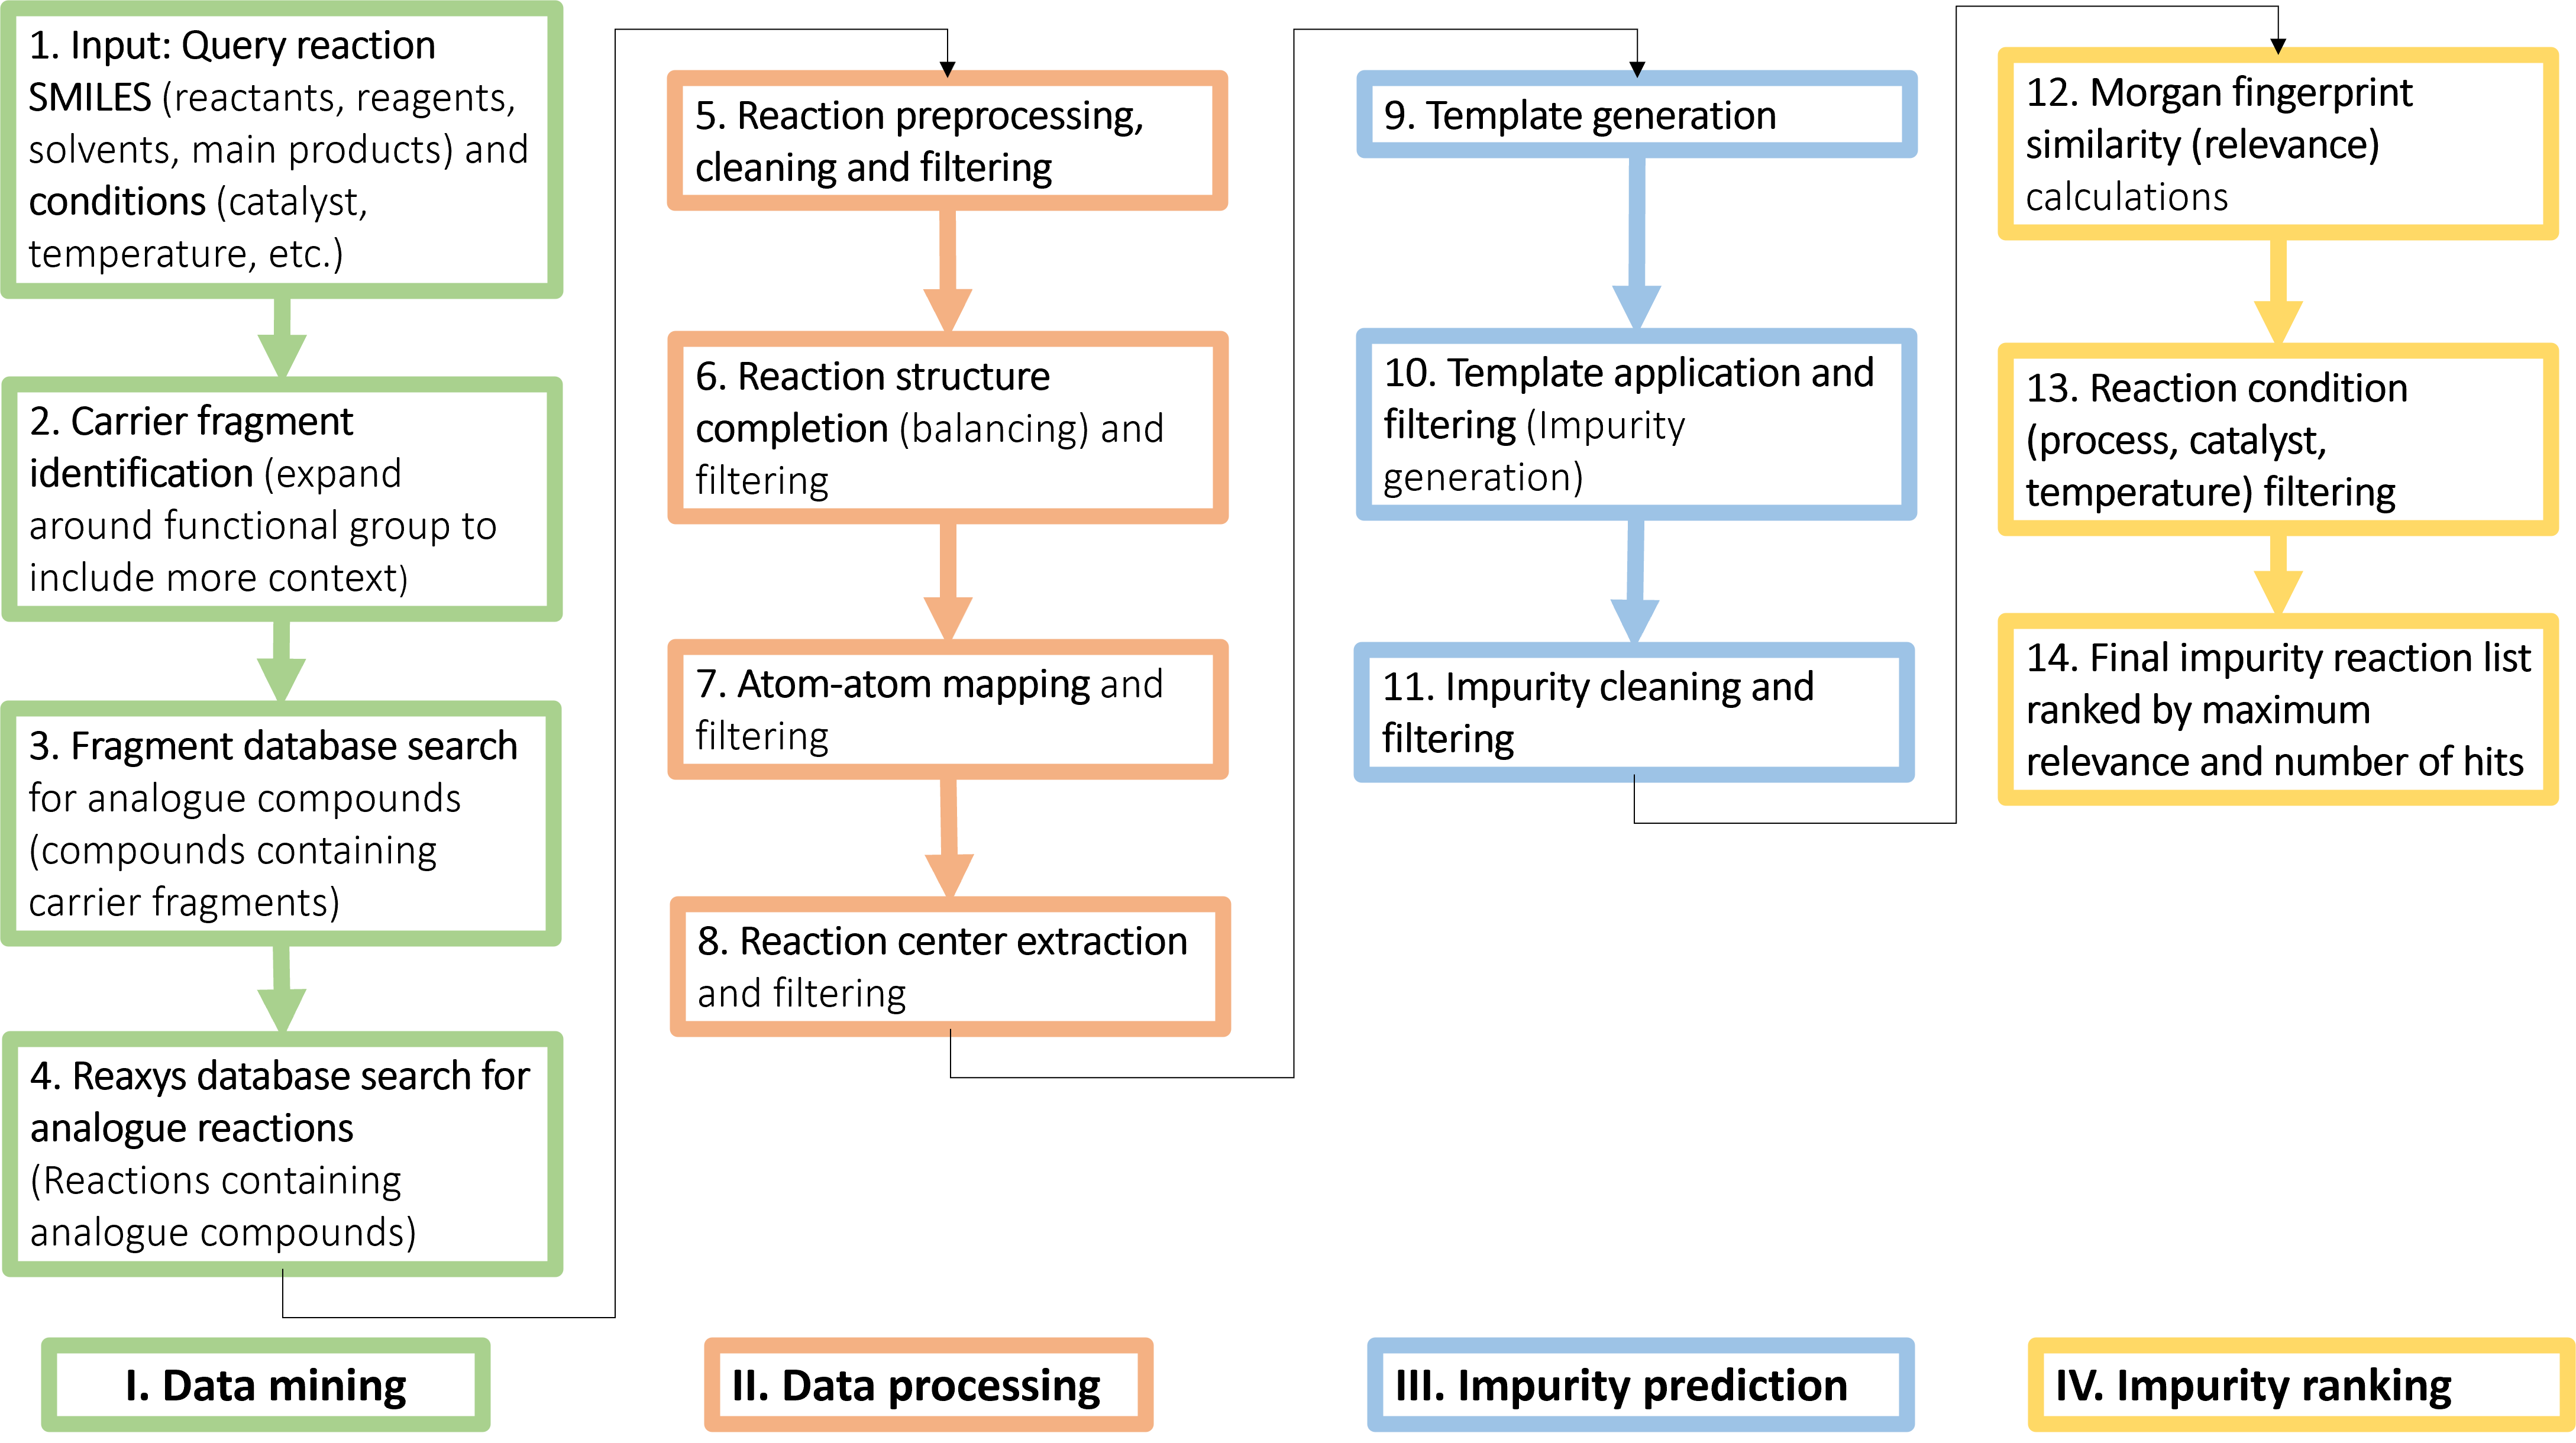

An example is shown in the following sections for a paracetamol case study. The relevant reaction scheme is shown below: (a) denotes the main reaction producting Paracetamol and (b) is the impurity reaction that should be predicted.

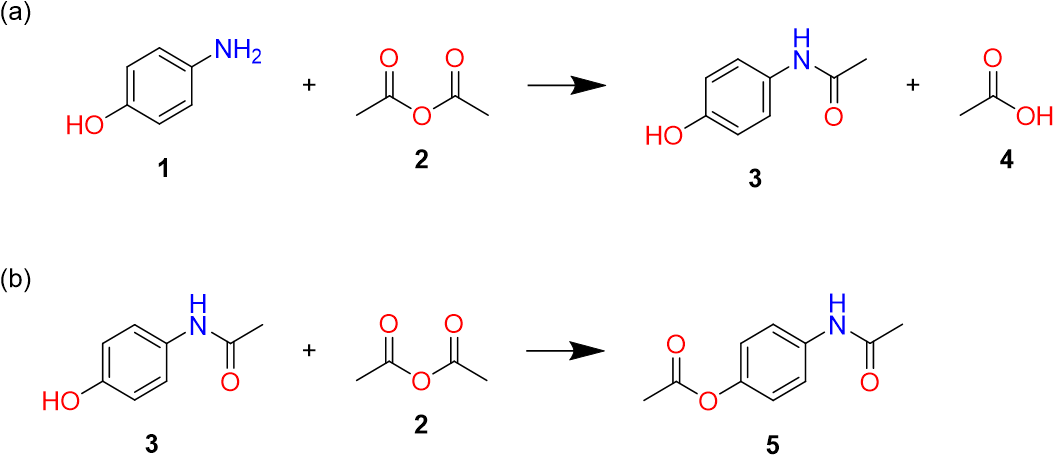

# Prerequisites

## Installation

The user is advised to follow installation instructions in the github repository as per `https://github.com/sustainable-processes/Impurity-Project`: 

Navigate to local project directory and:

`git clone https://github.com/sustainable-processes/Impurity-Project.git`

OR

`git clone git@github.com:sustainable-processes/Impurity-Project.git` if SSH is configured

To install dependencies, type the following in anaconda prompt or a compatible IDE:

`conda env create -f environment_win.yml -n <your-env-name>` if OS is windows, replace `your-env-name` with your choice

OR

`conda env create -f environment_linux.yml -n <your-env-name>` if OS is linux

Remember to activate the environment via `conda activate <your-env-name>`. Run the cell below, to make sure more than one output can be displayed at a time and basic functions are imported. For each section subsequently, read carefully and run the cells in order.


In [1]:
from IPython.core.interactiveshell import InteractiveShell #Allow more than one output
InteractiveShell.ast_node_interactivity = "all"
!conda info
from MainFunctions import openpickle
import pandas as pd
from rdkit import Chem
from rdkit.Chem import rdChemReactions


     active environment : impurityproject
    active env location : /home/aa2133/miniconda3/envs/impurityproject
            shell level : 2
       user config file : /home/aa2133/.condarc
 populated config files : 
          conda version : 4.11.0
    conda-build version : not installed
         python version : 3.8.3.final.0
       virtual packages : __linux=4.4.0=0
                          __glibc=2.23=0
                          __unix=0=0
                          __archspec=1=x86_64
       base environment : /home/aa2133/miniconda3  (writable)
      conda av data dir : /home/aa2133/miniconda3/etc/conda
  conda av metadata url : None
           channel URLs : https://repo.anaconda.com/pkgs/main/linux-64
                          https://repo.anaconda.com/pkgs/main/noarch
                          https://repo.anaconda.com/pkgs/r/linux-64
                          https://repo.anaconda.com/pkgs/r/noarch
          package cache : /home/aa2133/miniconda3/pkgs
                      

In [12]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data

The workflow requires prerequisite data in the form of a reaction dataframe, substance dataframe, and fragment dataframe (major requirements). There are also some minor requirements which require some transformation of the major dataframes which is also explained. The below sections give an overview of the data formats required. The user is recommended to store each of these major dataframes and minor data in a folder and store the folder file path as a variable. This is stored below under `masterdbreadpath`.

In [3]:
masterdbreadpath="/home/aa2133/Impurity-Project/Reaxys_Data/" # Change as required

### Reaction dataframe

A major source of data for this project is a reaction dataframe,`reactiondb`, stored in the `rxnsource` file path and consisting of approximately 17 million reactions downloaded from Reaxys. Considering the entirety of Reaxys as a reaction network (nodes as molecules and edges linking molecules involved in reaction), this set of reactions was taken from the core (substance 774355 with a search depth of 10 steps forward and 1 backward). A proprietary API was used to retrieve these reactions.

In [6]:
rxnsource=masterdbreadpath+'ReactionDB2.pickle'

In [7]:
reactiondb=pd.read_pickle(rxnsource)

`reactiondb` has 23 columns: 
* **Reaction ID** (Reaxys ID, can be other databases too) --INDEX
* **Instance** (Each reaction can have more than one set of unique conditions) --INDEX
* **NumRefs** (Number of references indicating the reaction)
* **ReactantID** (Reaxys ID for reactants, can be other databases too)
* **MissingReactant** (Reactants that are indicated in Reaxys as raw text but cannot be processed/don't have mol files or SMILES)
* **Product ID** (Reaxys ID for products, can be other databases too)
* **MissingProduct** (Products that are indicated in Reaxys as raw text but cannot be processed/don't have mol files or SMILES)
* **NumSteps** (Number of steps associated with the reaction ie. single or multi-step)
* **NumStages** (Number of stages associated with the reaction)
* **ReagentID** (Reaxys ID for reagents, can be other databases too)
* **MissingReagent** (Reagents that are indicated in Reaxys as raw text but cannot be processed/don't have mol files or SMILES)
* **Temperature** (Temperature of reaction instance, can be either single number or a range)
* **Pressure** (Pressure of reaction instance)
* **ReactionTime** (Time taken for reaction to occur)
* **SolventID** (Reaxys ID for solvents, can be other databases too)
* **MissingSolvent** (Solvents that are indicated in Reaxys as raw text but cannot be processed/don't have mol files or SMILES)
* **CatalystID** (Reaxys ID for catalysts, can be other databases too)
* **MissingCatalyst** (Catalysts that are indicated in Reaxys as raw text but cannot be processed/don't have mol files or SMILES)
* **ConditionNotes** (Additional notes on reaction conditions)
* **ReactionType** (Class of reactions)
* **NameDict** (Dictionary with keys as Reaxys IDs and values as species names)
* **YearPublished** (Year published)
* **Yield** (Dictionary with keys as Reaxys IDs and values as percentage yields

An example is shown below for reaction 8624923. Other data sources (besides Reaxys) can be used as long as the previous columns exist in the dataframe 

In [22]:
reactiondb.xs(8624923,drop_level=False)
reactiondb.xs(8624923,drop_level=False).dtypes

NumRefs         ReactantID MissingReactant ProductID  \
ReactionID Instance                                                         
8624923    0               6  [1427741, 385737]              []   [98170]   
           1               6  [1427741, 385737]              []   [98170]   
           2               6  [1427741, 385737]              []   [98170]   
           3               6  [1427741, 385737]              []   [98170]   
           4               6  [1427741, 385737]              []   [98170]   
           5               6  [1427741, 385737]              []   [98170]   

                    MissingProduct NumSteps  NumStages           ReagentID  \
ReactionID Instance                                                          
8624923    0                    []        1          1           [3587194]   
           1                    []        1          2  [2037554, 3587155]   
           2                    []        1          1           [2037554]   
           3                    []        1          2  [3587194, 1098229]   
           4                    []        1          1           [2037554]   
           5                    []        1          1           [2037554]   

                    MissingReagent      Temperature  ... ReactionTime  \
ReactionID Instance                                  ...                
8624923    0                    []         [0 - 25]  ...          [3]   
           1                    []             [60]  ...          [1]   
           2                    []             [20]  ...         [16]   
           3                    []     [0 - 25, 25]  ...      [3, 18]   
           4                    []             [60]  ...           []   
           5                    []  [49.85 - 59.85]  ...          [1]   

                    SolventID MissingSolvent CatalystID MissingCatalyst  \
ReactionID Instance                                                       
8624923    0               []             []         []              []   
           1               []             []         []              []   
           2         [741857]             []         []              []   
           3               []             []         []              []   
           4               []             []         []              []   
           5               []             []         []              []   

                    ConditionNotes   ReactionType  \
ReactionID Instance                                 
8624923    0                        [Acetylation]   
           1                                   []   
           2                                   []   
           3                                   []   
           4                                   []   
           5                                   []   

                                                              NameDict  \
ReactionID Instance                                                      
8624923    0         {1427741: 'D-glucuronic acid', 385737: 'acetic...   
           1         {1427741: 'D-glucuronic acid', 385737: 'acetic...   
           2         {1427741: 'D-glucuronic acid', 385737: 'acetic...   
           3         {1427741: 'D-glucuronic acid', 385737: 'acetic...   
           4         {1427741: 'D-glucuronic acid', 385737: 'acetic...   
           5         {1427741: 'D-glucuronic acid', 385737: 'acetic...   

                    YearPublished          Yield  
ReactionID Instance                               
8624923    0               [2000]  {98170: 82.0}  
           1               [2011]  {98170: 66.0}  
           2               [2001]  {98170: 62.0}  
           3               [2004]  {98170: 55.0}  
           4               [2003]  {98170: 50.0}  
           5               [2005]  {98170: 49.8}  

[6 rows x 21 columns]

NumRefs             Int64
ReactantID         object
MissingReactant    object
ProductID          object
MissingProduct     object
NumSteps           object
NumStages           Int64
ReagentID          object
MissingReagent     object
Temperature        object
Pressure           object
ReactionTime       object
SolventID          object
MissingSolvent     object
CatalystID         object
MissingCatalyst    object
ConditionNotes     string
ReactionType       object
NameDict           object
YearPublished      object
Yield              object
dtype: object

### Substance dataframe

**Major**

The substance dataframe, `substancedb`, is stored in the `substancesource` file path and contains data on all ~16 million species in the reaction dataframe, namely **SubstanceID** (Reaxys ID), **Smiles**, and **>1 Compound** which identifies whether the species is a mixture of any kind ('.' in SMILES eg. salt) or not. The proprietary API was used again to retrieve mol files which were then processed by RDKit and canonicalized into SMILES. Alternate substance dataframes could be used as long as it is in the correct format. 

In [9]:
substancesource=masterdbreadpath+'SubstanceSmiles.pickle'

In [5]:
substancedb=pd.read_pickle(substancesource)

In [50]:
substancedb[:10]
substancedb.dtypes

,Smiles,>1 Compound
SubstanceID,,
6890270,CC(C)(C)[C@@H]1CC[C@@](C)(F)[C@H](Br)C1,False
27615522,Cc1cc(-c2nc3cc(F)ccc3c3cc4c(cc23)OCO4)ccc1F,False
29164535,[Gd+3].[Na+].[O-]B([O-])[O-].[Tb+3],True
11230426,Nc1cc(F)c(N2CC(F)C2)c(F)c1,False
9019791,CCCCOc1ccc(-c2nc(-c3ccc(Cl)cc3)[nH]c2-c2ccncc2...,False
4584084,CC(C)(C)OC(=O)C=C1C[N+]([O-])=C(c2ccccc2F)c2cc...,False
918811,Cc1cc([N+](=O)[O-])cc([N+](=O)[O-])c1NN,False
11185773,Cc1ccccc1CCCCCCC(=O)c1ncc(-c2ccccn2)o1,False
6156831,CCOC(=O)c1c(-c2cccc([N+](=O)[O-])c2)cc(-c2cccc...,False


Smiles          string
>1 Compound    boolean
dtype: object

**Minor**

Processing Reaxys species could lead to errors (eg. valence errors, kelulization errors, missing mol files etc.). Therefore, a set of species with these errors was assembled as `unresolvedids` stored under the file path specified by `unresolvedsource`. Note that each ID is a Reaxys ID. This is optional, mostly for data quality purposes.

In [10]:
unresolvedsource=masterdbreadpath+'UnresolvedIDs.pickle'

In [11]:
unresolvedids=openpickle(unresolvedsource)

In [178]:
len(unresolvedids)
list(unresolvedids)[:20]

1403428

[16777216,
 1,
 16777223,
 8388629,
 16777240,
 20971545,
 16777244,
 16777247,
 29360173,
 8388667,
 16777286,
 29360211,
 29360212,
 29360213,
 29360214,
 29360215,
 29360216,
 16777304,
 8388693,
 8388699]

Another important factor to consider is reaction role assignment. For the data mining module in Section 3.1, analogue reactions are retrieved based on the criteria that both reactants and reagents are analogue (different solvents and catalysts are permitted to allow for sufficient results). However, a species can act as a reagent in a certain reaction but also as a catalyst in others, and sometimes it is not clear exactly what its role is in a reaction database. `exemptionlist`, stored under file path `exemptionsource` is a list of species that occur as a catalyst in more than 5 % of reactions they are involved in.  If a species is in `exemptionlist`, even if it is non-analogue as a reagent the reaction will still be considered in the off-chance that it behaves as a catalyst. This is optional.

In [12]:
exemptionsource=masterdbreadpath + "PotCatList.pickle"

In [13]:
exemptionlist=openpickle(exemptionsource)

In [183]:
exemptionlist[:10]

[1142, 1222, 1368, 1429, 1453, 2071, 2752, 2815, 3162, 3956]

### Fragment dataframe

**Major**

The final input is a fragment dataframe, `fragdb` which will be needed in Step 4 of the workflow. This is a dataframe containing all carrier fragments expanded from identified functional groups for each species in the substance dataframe. An example is shown below for generating this fragment dataframe with an expansion value of 1 (For each species, each identified functional group is expanded to the nearest neighboring atom (s)). Note that the operation has been parallelized across 16 CPU cores; the user is advised to change `ncpus` based on the system being used.

In [45]:
from FunctionsDB import createfragdb

In [46]:
fragdb=createfragdb(substancedb,ncpus=16,resFormat='smiles')

2022-08-17 10:07:33,454	INFO services.py:1171 -- View the Ray dashboard at http://127.0.0.1:8265


`fragdb` has 5 columns:

* **FragmentSmiles** (SMILES of carrier fragment present in species)
* **SubstanceID** (Reaxys ID of species)
* **Smiles** (SMILES of species)
* **>1 Compound** (True if species is a mixture)
* **count** (Number of associated carrier fragments present in species)

In [7]:
fragdb[:10]

,,count,Smiles,>1 Compound
FragmentSmiles,SubstanceID,,,
CF,6890270,1,CC(C)(C)[C@@H]1CC[C@@](C)(F)[C@H](Br)C1,False
CBr,6890270,1,CC(C)(C)[C@@H]1CC[C@@](C)(F)[C@H](Br)C1,False
cnc,27615522,1,Cc1cc(-c2nc3cc(F)ccc3c3cc4c(cc23)OCO4)ccc1F,False
cF,27615522,2,Cc1cc(-c2nc3cc(F)ccc3c3cc4c(cc23)OCO4)ccc1F,False
[H]C1([H])OccO1,27615522,1,Cc1cc(-c2nc3cc(F)ccc3c3cc4c(cc23)OCO4)ccc1F,False
[Gd+3],29164535,1,[Gd+3].[Na+].[O-]B([O-])[O-].[Tb+3],True
[Na+],29164535,1,[Gd+3].[Na+].[O-]B([O-])[O-].[Tb+3],True
[O-]B([O-])[O-],29164535,1,[Gd+3].[Na+].[O-]B([O-])[O-].[Tb+3],True
[Tb+3],29164535,1,[Gd+3].[Na+].[O-]B([O-])[O-].[Tb+3],True


The above fragment dataframe can be written to a pickle file and read for future usage, shown below. For this tutorial it is stored in the `fragdbsource` file path.

In [6]:
fragdbsource=masterdbreadpath+'fragdb.pickle'

In [7]:
fragdb=pd.read_pickle(fragdbsource)

Visualization of fragments for a particular species can be easily performed using the `visfragment` function, as shown below. The widgets can be controlled to see which fragments are present in a species.

In [244]:
from Visualize import visfragment

In [245]:
visfragment(fragdbsource=fragdb[:12],displayres=True)

<h3><center><strong>Species</strong></center></h3>

<h3><center><strong>Fragments</strong></center></h3>

Output()

**Minor**

A fragment frequency dataframe, `fragfreq` is another required input. It contains 3 columns: `FragmentSmiles`; `Frequency`, the frequency of the fragment in `substancedb`; and `Popularity`, the percentage popularity of the fragment. Generation is easily performed by invoking the `genfragfreq` function on `fragmentdb`, and sorting based on the popularity column (percentage occurrence) as shown below. Only the top 10 fragments (SMILES) are shown.

In [169]:
from FunctionsDB import createfragfreq

In [170]:
fragfreq=createfragfreq(fragdb)
fragfreq.sort_values(by=['Popularity'],ascending=False)[:10]

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,FragmentSmiles,Frequency,Popularity
2,cnc,2820013,6.0
13,cOC,2743793,5.0
41,COC(C)=O,1765485,4.0
32,[H]OC,2176832,4.0
15,cCl,1362946,3.0
33,COC,1693827,3.0
37,CN(C)C,993693,2.0
75,[H]Oc,756164,2.0
89,c=O,915341,2.0
99,cn(c)C,933230,2.0


`fragfreq` can be written to a pickle file and stored, in this case, the file path under `fraggroupssource`.

# Workflow demo

A workflow demo is shown below for the paracetamol case study, going through all 14 steps. 3.1 covers data mining (steps 1-4), 3.2 covers data processing (steps 5 - 8) , 3.3 covers impurity prediction (steps 9 - 11) and 3.4 covers impurity ranking (steps 12 - 14) with the final visualization of the results. The workflow was run on a linux server (Ubuntu 16.04.6 LTS, x86_64, 32 CPUs (Intel(R) Xeon(R) CPU E5-2650 v2 @ 2.60GHz)).

The workflow takes in a configuration dictionary, `IP` which includes all the necessary prerequisite major and minor data requirements. Here, the dataframes are directly specified, and `showresults` is specified as True and `writetofile` is specified as False. Be advised that this will require anywhere between 80 and 90 gb of memory due to parallel processing across 16 cores.If the user wishes to save memory, it is better to write each dataframe to a pickle file, refresh the kernel, and specify file paths instead. Specify `showresults` as False, `writetofile` as True and add `folderwritepath` (directory to store results) to IP. The workflow routine automatically will read and write the necessary data. 

In [ ]:
IP={'substancedb':substancedb, #*MANDATORY* Substance dataframe, specify either a file path (substancesource) or a loaded dataframe (substancedb)
    'rxnsource': reactiondb,   # *MANDATORY* Reaction dataframe, specify either a file path (rxnsource) or a loaded dataframe (reactiondb)
    'fragdbsource':fragdb,     # *MANDATORY* Fragment dataframe, specify either a file path (fragdbsource) or a loaded dataframe (fragdb)
    'unresolvedsource':unresolvedids, #Unresolved Reaxys IDs, specify file path (unresolvedsource), list (unresolvedids) or None
    'exemptionsource':exemptionlist,  #List of species that could be catalysts, specify file path (exemptionsource), list (exemptionlist) or None
    'fraggroupssource':fragfreq,       # Fragment frequency dataframe, specify file path (fraggroupssource) or dataframe (fragfreq) or None
   'showresults':True,         # Whether results are directly returned or not, specif False to save memory
   'writetofile':False}        #Whether results are written to file or not (add folderwritepath to dictionary), specify True to save memory
                               # eg. 'folderwritepath': "/home/aa2133/Impurity-Project/Input/"

## Data mining (Steps 1 - 4)

The data mining module seeks to identify carrier fragments (based on functional groups) in each query species identified in a reaction passed in by a user, retrieve analogue species that contain these carrier fragments as well as all analogue reactions that contain these analogue species.

**Input**

As outlined in step 1, based on the paracetamol query reaction, the user input should be a reaction SMILES containing all possible reactants, reagents, solvents and catalysts on the left-hand-side and all possible products on the right-hand-side. This reaction is visualized by RDKit below.

Reaction SMILES: Nc1ccc(O)cc1.CC(=O)OC(C)=O>>CC(=O)Nc1ccc(O)cc1.CC(=O)O


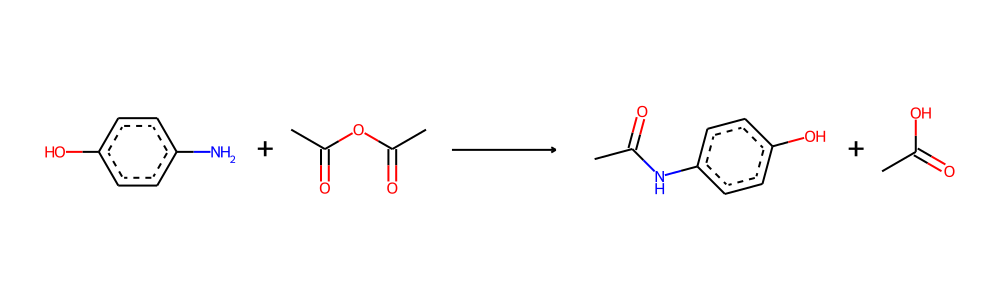

In [27]:
print("Reaction SMILES: Nc1ccc(O)cc1.CC(=O)OC(C)=O>>CC(=O)Nc1ccc(O)cc1.CC(=O)O")
from MainFunctions import drawReaction
drawReaction(rdChemReactions.ReactionFromSmarts("Nc1ccc(O)cc1.CC(=O)OC(C)=O>>CC(=O)Nc1ccc(O)cc1.CC(=O)O",useSmiles=True))

Subsequently, passing this input into the workflow is performed by invoking the `main` function. The function takes in a `casename` (to create directories to store outputs in); a list of `steps` to perform; `userinput` which is the reaction SMILES string above; any catalysts, `catalyst`; and temperature range, `Trange`. The latter two arguments are not relevant to this case study and therefore are not added. The last argument is an input parameter dictionary, `IP`, containing all relevant parameters for steps (a default is automatically initiated and it is up to the user to pass in any changes as additional arguments. 

An example is shown below for the data mining section of the workflow (steps 2 to 4) which retrieves analogue reactions containing analogue species that have any carrier fragments present in species in the `userinput` reaction SMARTS string. Here results are not written to file to save time. A full list of available parameters to tweak can be seen in the `main` function body and docustring.

In [15]:
IP.update({'reaxys_updated':True, # Whether reactiondb already has been updated by Reaxys and has the correct 23-column format
   'reaxys_update':False,      # Whether existing reactions need to be updated by Reaxys (not available as API cannot be shared)
    'expand': 1,                # How many atoms to expand identified functional groups by, forming carrier fragments
   'ncpus': 16,                # Number of CPUs to perform function call on (change depending on the system)
    'workflow':'strict',       # Workflow to run, strict means reactions are considered analogue only if reactants and reagents are analogue
    'returnall':False})         # Whether all workflows are run and returned

In [5]:
from MainScript import main

In [17]:
IP=main('Case2',steps=[2,3,4],userinput="Nc1ccc(O)cc1.CC(=O)OC(C)=O>>CC(=O)Nc1ccc(O)cc1.CC(=O)O",**IP)

Step 2 complete


2022-08-24 09:39:04,330	INFO services.py:1171 -- View the Ray dashboard at http://127.0.0.1:8266
2022-08-24 09:39:42,422	INFO services.py:1171 -- View the Ray dashboard at http://127.0.0.1:8266
2022-08-24 09:40:18,311	INFO services.py:1171 -- View the Ray dashboard at http://127.0.0.1:8266
2022-08-24 09:40:54,825	INFO services.py:1171 -- View the Ray dashboard at http://127.0.0.1:8266
2022-08-24 09:41:28,371	INFO services.py:1171 -- View the Ray dashboard at http://127.0.0.1:8266
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ver

Step 3 complete


2022-08-24 09:42:23,749	INFO services.py:1171 -- View the Ray dashboard at http://127.0.0.1:8266


Step 4 complete


**Output**

Given all data requirements, the data mining module completes in roughly 9-14 minutes for this case study depending on the available computing resources. If more modern architecture is used with equivalent or more cores dedicated to the task, the speedup will be much higher. The output is the IP dictionary, updated with several outputs that will be outlined here in a step-wise fashion. The user is advised to load the necessary pickle files, if `writetofile` was True and `showresults` was False.

The main output is `inputquery_analg` which is a dictionary containing query species, carrier fragments and dataframe of analogue species for each

In [23]:
IP['inputquery_analg']['species']['CC(=O)Nc1ccc(O)cc1'].keys() #List of carrier fragments for paracetamol
IP['inputquery_analg']['species']['CC(=O)Nc1ccc(O)cc1']['[H]Oc']['analoguepool'][:10] #Analogue pool for Paracetamol

dict_keys(['[H]Oc', '[H]N(c)C(C)=O'])

,count,Smiles,>1 Compound
SubstanceID,,,
21907199,1,O=C1CSc2ccccc2N1Cc1nnc(S)n1N=Cc1ccc(O)cc1,False
10278961,1,Cc1[nH]c(O)nc2nc(=O)n(Nc3ccc([N+](=O)[O-])cc3)...,False
14867002,1,CC(C)=C1C(=O)N(c2ccc(O)cc2)C(=O)/C1=C(\C)c1cc(...,False
2375210,1,CCCCN=Cc1cc([N+](=O)[O-])ccc1O,False
24042399,1,CC(C)(C)n1nccc1-c1c2ccc(c1O)CCc1ccc(cc1)CC2,False
19530662,1,Cc1nn(S(=O)(=O)c2ccccc2)c2ncc(-c3cc(OC[C@H](Cc...,False
4651745,1,CC[C@H](C)[C@@H]1NC(=O)[C@H](Cc2ccc(O)cc2)NC(=...,False
11733725,1,CCC(Cc1ccccc1Cl)c1cc(O)c(C(c2ccccc2)C2CC2)c(=O)o1,False
26735158,2,O=C(OCc1cc(O)ccc1O[C@@H]1O[C@H](CO)[C@@H](O)[C...,False


The other output is a dataframe of analogue reactions that contain these analogue species as shown below

In [22]:
IP['analoguerxns'][13270:13280]
print(f"There are {len(IP['analoguerxns'])} analogue reactions")

NumRefs        ReactantID MissingReactant  ProductID  \
ReactionID Instance                                                         
2380306    0              14  [385737, 605970]              []  [1940871]   
           1              14  [385737, 605970]              []  [1940871]   
           2              14  [385737, 605970]              []  [1940871]   
           3              14  [385737, 605970]              []  [1940871]   
           6              14  [385737, 605970]              []  [1940871]   
           8              14  [385737, 605970]              []  [1940871]   
           9              14  [385737, 605970]              []  [1940871]   
           11             14  [385737, 605970]              []  [1940871]   
           13             14  [385737, 605970]              []  [1940871]   
3965377    0               1         [2521399]              []   [985035]   

                    MissingProduct NumSteps  NumStages ReagentID  \
ReactionID Instance                                                
2380306    0                    []        1          1        []   
           1                    []        1          1  [506007]   
           2                    []        1          1  [506007]   
           3                    []        1          1  [506007]   
           6                    []        1          1  [506007]   
           8                    []        1          1  [506007]   
           9                    []        1          1  [506007]   
           11                   []        1          1        []   
           13                   []        1          1        []   
3965377    0                    []        1          1        []   

                                                        MissingReagent  \
ReactionID Instance                                                      
2380306    0                      [silica-sulfuric acid nanoparticles]   
           1                                                        []   
           2                                                        []   
           3                                                        []   
           6                                                        []   
           8                                                        []   
           9                                                        []   
           11                            [silica-supported boric acid]   
           13        [poly(4-vinylpyridine) supported copper(II) ox...   
3965377    0                              [N<sub>4</sub>S<sub>4</sub>]   

                    Temperature  ... ReactionTime SolventID  \
ReactionID Instance              ...                          
2380306    0               [20]  ...   [0.166667]        []   
           1              [110]  ...          [2]        []   
           2              [110]  ...           []        []   
           3              [110]  ...          [2]        []   
           6                 []  ...          [1]        []   
           8              [110]  ...          [2]        []   
           9                 []  ...           []        []   
           11              [50]  ...          [1]        []   
           13              [20]  ...  [0.0833333]        []   
3965377    0                 []  ...         [24]  [635760]   

                          MissingSolvent CatalystID MissingCatalyst  \
ReactionID Instance                                                   
2380306    0         [neat (no solvent)]         []              []   
           1                          []         []              []   
           2                          []         []              []   
           3                          []         []              []   
           6                          []         []              []   
           8                          []         []              []   
           9                          []         []              

There are 243603 analogue reactions


The necessary arguments can be passed to the `vismaster` function to visualize the outputs outlined above.Visualization of analogue reactions is shown in the next section.

In [236]:
from Visualize import vismaster

In [214]:
vismaster(**IP)

#### <center>Select a stage to visualize</center>

Output()

## Data processing (Steps 5 - 8)

The data processing portion of the workflow consists of steps 5 to 8 and involves processing the analogue reactions obtained in data mining for template generation.

In [31]:
getspecdat_rxn("CC(=O)OC(C)=O.O=c1oc2cc(O)ccc2c2[nH]c3cc(O)ccc3c12>>CC(=O)Oc1ccc2c(c1)[nH]c1c3ccc(OC(C)=O)cc3oc(=O)c21")

({0: {'atomdict': {'C': 4, 'O': 3, 'H': 6},
   'charge': 0,
   'smiles': 'CC(=O)OC(C)=O',
   'formula': 'C4H6O3',
   'count': 1},
  1: {'atomdict': {'O': 4, 'C': 15, 'N': 1, 'H': 9},
   'charge': 0,
   'smiles': 'O=c1oc2cc(O)ccc2c2[nH]c3cc(O)ccc3c12',
   'formula': 'C15H9NO4',
   'count': 1}},
 {0: {'atomdict': {'C': 19, 'O': 6, 'N': 1, 'H': 13},
   'charge': 0,
   'smiles': 'CC(=O)Oc1ccc2c(c1)[nH]c1c3ccc(OC(C)=O)cc3oc(=O)c21',
   'formula': 'C19H13NO6',
   'count': 1}},
 {},
 {})

In [131]:
checkdemo = widgets.Checkbox(
                value=False,
                description="Restrict available reactions to this step",
                disabled=False,
                indent=False,
            )
def on_update_checkdemo(*args):
    if checkdemo.value:
        print('Yaya')
    else:
        print('Nah')
checkdemo.observe(on_update_checkdemo,"value")
display(checkdemo)

Checkbox(value=False, description='Restrict available reactions to this step', indent=False)

Yaya
Nah
Yaya
Nah
Yaya
Nah


In [163]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [196]:
from MainFunctions import mol_with_atom_index,molfromsmiles

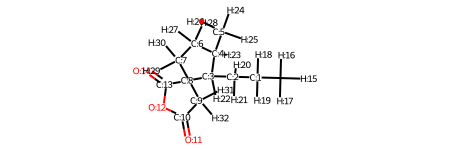

In [213]:
mol_with_atom_index(Chem.AddHs(molfromsmiles('[CH3:1][CH2:2][CH2:3][CH:4]1[CH:5]([CH3:6])[CH2:7][CH2:8][C:9]12[CH2:10][C:11](=[O:12])[O:22][C:20]2=[O:21]')))


In [204]:
IP['analoguerxnsmapped'].xs(4055824).mapped_rxn.iloc[0]

'[CH3:1][CH2:2][CH2:3][CH:4]1[CH:5]([CH3:6])[CH2:7][CH2:8][C:9]12[CH2:10][C:11](=[O:12])[O:22][C:20]2=[O:21].[NH2:13][c:14]1[cH:15][cH:16][cH:17][cH:18][cH:19]1>>[CH3:1][CH2:2][CH2:3][CH:4]1[CH:5]([CH3:6])[CH2:7][CH2:8][C:9]1([CH2:10][C:11](=[O:12])[NH:13][c:14]1[cH:15][cH:16][cH:17][cH:18][cH:19]1)[C:20](=[O:21])[OH:22]'

In [220]:
IP['analoguerxns'].xs(44952788)

,NumRefs,ReactantID,MissingReactant,ProductID,MissingProduct,NumSteps,NumStages,ReagentID,MissingReagent,Temperature,...,ReactionTime,SolventID,MissingSolvent,CatalystID,MissingCatalyst,ConditionNotes,ReactionType,NameDict,YearPublished,Yield
Instance,,,,,,,,,,,,,,,,,,,,,
0,1,"[1877810, 2519761]",[],[30976106],[],1,1,[],[],[60],...,[12],[1718733],[],[],[],,[],"{1877810: '3,5-di-tert-butyl-2-hydroxybenzalde...",[2017],{}


In [219]:
set(IP['analoguerxnsvalid'].index)-set(IP['analoguerxnstempl'].index)

{(44952788, 0),
 (47452664, 0),
 (30824698, 6),
 (1794695, 0),
 (9410297, 0),
 (41522466, 0),
 (4570829, 0),
 (23494859, 0),
 (3511867, 0),
 (2818708, 0),
 (2906516, 0),
 (35638058, 0),
 (4817680, 12),
 (32629317, 0),
 (2784679, 0),
 (24726256, 0),
 (2568530, 1),
 (23832275, 4),
 (37808975, 0),
 (28497030, 0),
 (4702032, 0),
 (38117921, 0),
 (38842848, 0),
 (9881952, 0),
 (33071203, 0),
 (11281628, 0),
 (25598401, 0),
 (36316147, 3),
 (46758194, 0),
 (2191089, 0),
 (40995227, 0),
 (47409067, 0),
 (3392193, 0),
 (35583230, 0),
 (47496613, 0),
 (2906284, 0),
 (1759910, 0),
 (30138283, 0),
 (24440430, 0),
 (29565096, 0),
 (2036564, 0),
 (1550923, 0),
 (23593707, 1),
 (46911829, 0),
 (3236193, 0),
 (36278418, 0),
 (473330, 1),
 (46546026, 0),
 (3139183, 0),
 (608326, 3),
 (37820894, 0),
 (36771134, 0),
 (2103311, 0),
 (2906448, 0),
 (558178, 0),
 (40198799, 0),
 (4999417, 0),
 (28913857, 0),
 (36616871, 0),
 (609029, 96),
 (834966, 0),
 (11125664, 0),
 (44254905, 0),
 (261517, 0),
 (112128

In [254]:
demlist=[1,1,23]
demlist+=list((1,233,25))
demlist

[1, 1, 23, 1, 233, 25]

In [306]:
colors = [(0.7, 1, 0.7),(1, 0.7, 0.7)]
highlightAtomLists=[[19, 10, 9, 1, 2, 0, 3,4,5]]
highlightAtomColors={}
highlightAtomColors.update({10:colors[1],5:colors[1]})
highlightAtomColors.update({atm:colors[0] for atm in highlightAtomLists[0] if atm not in highlightAtomColors})
highlightBondColors=[{9:colors[1]}]
highlightBondColors=[{}]
# highlightBonds=[[0,10,20,9,1,2]]
# highlightBondsColors={bnd:colors[0] for bnd in highlightBonds[0]}
# highlightAtomColors.update({10:colors[1]})
# highlightBondColors.update({20:colors[1],10:colors[1],9:colors[1]})

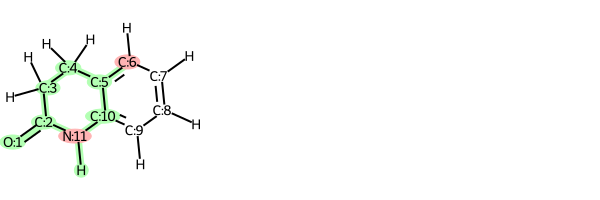

In [343]:
IPythonConsole.drawOptions.addBondIndices = False
IPythonConsole.drawOptions.addAtomIndices = False
IPythonConsole.drawOptions.legendFraction=0
IPythonConsole.drawOptions.legendFontSize=50
IPythonConsole.drawOptions.padding=0
# IPythonConsole.drawOptions.fixedFontSize=-1
# IPythonConsole.drawOptions.legendFraction=0.8
Draw.MolsToGridImage([Chem.AddHs(molfromsmiles('[O:1]=[C:2]1[CH2:3][CH2:4][c:5]2[cH:6][cH:7][cH:8][cH:9][c:10]2[NH:11]1'))],highlightAtomLists=highlightAtomLists,highlightAtomColors=[highlightAtomColors],highlightBondColors=highlightBondColors)

In [344]:
# %%debug
vismaster(**IP)

#### <center>Select a stage to visualize</center>

Output()

In [30]:
balance_rxn("CC(=O)OC(C)=O.O=c1oc2cc(O)ccc2c2[nH]c3cc(O)ccc3c12>>CC(=O)Oc1ccc2c(c1)[nH]c1c3ccc(OC(C)=O)cc3oc(=O)c21")

Setting 'max_len_single_sentence' is now deprecated. This value is automatically set up.
Setting 'max_len_sentences_pair' is now deprecated. This value is automatically set up.
Keyword arguments {'return_special_tokens_masks': True} not recognized.
Setting 'max_len_single_sentence' is now deprecated. This value is automatically set up.
Setting 'max_len_sentences_pair' is now deprecated. This value is automatically set up.
Keyword arguments {'return_special_tokens_masks': True} not recognized.


Welcome to the CBC MILP Solver 
Version: 2.9.0 
Build Date: Feb 12 2015 

command line - /home/aa2133/miniconda3/envs/impurityproject/lib/python3.8/site-packages/pulp/apis/../solverdir/cbc/linux/64/cbc /tmp/2209b57faa3a4cd58661d610c346e610-pulp.mps ratio None allow None threads None presolve on strong None gomory on knapsack on probing on branch printingOptions all solution /tmp/2209b57faa3a4cd58661d610c346e610-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 9 COLUMNS
At line 35 RHS
At line 40 BOUNDS
At line 45 ENDATA
Problem MODEL has 4 rows, 4 columns and 13 elements
Coin0008I MODEL read with 0 errors
String of None is illegal for double parameter ratioGap value remains 0
String of None is illegal for double parameter allowableGap value remains 0
String of None is illegal for integer parameter threads value remains 0
String of None is illegal for integer parameter strongBranching value remains 5
Option for gomoryCuts changed from ifmove to on
Option

Traceback (most recent call last):
  File "/home/aa2133/miniconda3/envs/impurityproject/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_8583/2682836595.py", line 1, in <cell line: 1>
    balance_rxn("CC(=O)OC(C)=O.O=c1oc2cc(O)ccc2c2[nH]c3cc(O)ccc3c12>>CC(=O)Oc1ccc2c(c1)[nH]c1c3ccc(OC(C)=O)cc3oc(=O)c21")
  File "/home/aa2133/Impurity-Project/BalanceRxns.py", line 1992, in balance_rxn
    mappedrxn,confidence=maprxn([balrxnsmiles])
ValueError: not enough values to unpack (expected 2, got 1)

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/aa2133/miniconda3/envs/impurityproject/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 1993, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
  File "/home/aa2133/miniconda3/envs/impurityproject/lib/python3.8/site-packages/IPython/co

In [81]:
atmlist=[]
for rctid in demdict:
    atmlist+=[match for inst in demdict[rctid]['fragloc'] for frag in demdict[rctid]['fragloc'][inst] for match in demdict[rctid]['fragloc'][inst][frag]['corrmatches']]

In [82]:
atmlist
demdict

[(0, 1, 2, 3, 4, 5, 6), (20, 0, 1), (27, 13, 12)]

{385737: {'atomdict': {'C': 4, 'O': 3, 'H': 6},
  'charge': 0,
  'smiles': 'CC(=O)OC(C)=O',
  'formula': 'C4H6O3',
  'count': 1,
  'mixture': False,
  'mappedsmiles': ['[CH3:1][C:2](=[O:3])[O:27][C:18]([CH3:19])=[O:20]'],
  'cleanmol': [<rdkit.Chem.rdchem.Mol at 0x7f1b2b2d68b0>],
  'querycompds': {'CC(=O)OC(C)=O': ['CC(=O)OC(C)=O']},
  'fragloc': {0: {'CC(=O)OC(C)=O': {'corrmatches': [(0, 1, 2, 3, 4, 5, 6)],
     'funcgroupids': [{1, 2, 3, 4, 6}]}}},
  'reacfrag': {0: {'CC(=O)OC(C)=O': [0]}}},
 4813977: {'atomdict': {'O': 4, 'C': 15, 'N': 1, 'H': 9},
  'charge': 0,
  'smiles': 'O=c1oc2cc(O)ccc2c2[nH]c3cc(O)ccc3c12',
  'formula': 'C15H9NO4',
  'count': 1,
  'mixture': False,
  'mappedsmiles': ['[OH:4][c:5]1[cH:6][cH:7][c:8]2[c:9]([cH:10]1)[nH:11][c:12]1[c:13]3[cH:14][cH:15][c:16]([OH:17])[cH:21][c:22]3[o:23][c:24](=[O:25])[c:26]21'],
  'cleanmol': [<rdkit.Chem.rdchem.Mol at 0x7f1b13893630>],
  'querycompds': {'[H]Oc': ['CC(=O)Nc1ccc(O)cc1', 'Nc1ccc(O)cc1']},
  'fragloc': {0: {'[H]Oc': {

In [94]:
demdict2={'reacfrag': {0: {'[H]Oc': [1, 0]}}}
demdict2['reacfrag'].get(1)

In [190]:
IP['analoguerxnsmapped'].dtypes
# IP['analoguerxnsassigned'][['LHSdata','RHSdata','msg','msg1','msg2']].iloc[0].RHSdata
len(IP['analoguerxnsvalid'])
len(IP['analoguerxnscent'])
len(IP['analoguerxnsassigned'])
len(IP['analoguerxnsparsed'])
IP['analoguerxnscent'].dtypes
IP['analoguerxnsfinal'].iloc[0].LHSdata
IP['analoguerxnsvalid'].iloc[0]
IP['analoguerxnsfinal'].iloc[0].specmap

NumRefs          Int64
NumSteps        object
NumStages        Int64
rxnsmiles0      object
balrxnsmiles    object
msg             object
LHS             object
RHS             object
hcrct           object
hcprod          object
LHSdata         object
RHSdata         object
mapped_rxn      object
confidence      object
dtype: object

67881

72087

74411

129472

NumRefs             Int64
NumSteps           object
NumStages           Int64
rxnsmiles0         object
balrxnsmiles       object
msg                object
LHS                object
RHS                object
hcrct              object
hcprod             object
LHSdata            object
RHSdata            object
mapped_rxn         object
confidence         object
msg1               object
nofg               object
msg2               object
specmap            object
rnbmap             object
rxncentermapnum    object
rxncenter            bool
dtype: object

{385737: {'atomdict': {'C': 4, 'O': 3, 'H': 6},
  'charge': 0,
  'smiles': 'CC(=O)OC(C)=O',
  'formula': 'C4H6O3',
  'count': 1,
  'mixture': False,
  'mappedsmiles': ['[CH3:1][C:2](=[O:3])[O:27][C:18]([CH3:19])=[O:20]'],
  'cleanmol': [<rdkit.Chem.rdchem.Mol at 0x7f1b2b2d68b0>],
  'querycompds': {'CC(=O)OC(C)=O': ['CC(=O)OC(C)=O']},
  'fragloc': {0: {'CC(=O)OC(C)=O': {'corrmatches': [(0, 1, 2, 3, 4, 5, 6)],
     'funcgroupids': [{1, 2, 3, 4, 6}]}}},
  'reacfrag': {0: {'CC(=O)OC(C)=O': [0]}}},
 4813977: {'atomdict': {'O': 4, 'C': 15, 'N': 1, 'H': 9},
  'charge': 0,
  'smiles': 'O=c1oc2cc(O)ccc2c2[nH]c3cc(O)ccc3c12',
  'formula': 'C15H9NO4',
  'count': 1,
  'mixture': False,
  'mappedsmiles': ['[OH:4][c:5]1[cH:6][cH:7][c:8]2[c:9]([cH:10]1)[nH:11][c:12]1[c:13]3[cH:14][cH:15][c:16]([OH:17])[cH:21][c:22]3[o:23][c:24](=[O:25])[c:26]21'],
  'cleanmol': [<rdkit.Chem.rdchem.Mol at 0x7f1b13893630>],
  'querycompds': {'[H]Oc': ['CC(=O)Nc1ccc(O)cc1', 'Nc1ccc(O)cc1']},
  'fragloc': {0: {'[H]Oc': {

NumRefs                                                            1
NumSteps                                                           1
NumStages                                                          1
rxnsmiles0         CC(=O)OC(C)=O.O=c1oc2cc(O)ccc2c2[nH]c3cc(O)ccc...
balrxnsmiles       CC(=O)OC(C)=O.O=c1oc2cc(O)ccc2c2[nH]c3cc(O)ccc...
msg                               Balanced with help product(s): H2O
LHS                                                [385737, 4813977]
RHS                                                        [4824322]
hcrct                                                             []
hcprod                                                           [1]
LHSdata            {385737: {'atomdict': {'C': 4, 'O': 3, 'H': 6}...
RHSdata            {4824322: {'atomdict': {'C': 19, 'O': 6, 'N': ...
mapped_rxn         [CH3:1][C:2](=[O:3])[O:27][C:18]([CH3:19])=[O:...
confidence                                                  0.582353
msg1                              

{1: (385737, 0, 0, 4824322, 0, 0),
 2: (385737, 0, 1, 4824322, 0, 1),
 3: (385737, 0, 2, 4824322, 0, 2),
 27: (385737, 0, 3, 1, 0, 0),
 18: (385737, 0, 4, 4824322, 0, 17),
 19: (385737, 0, 5, 4824322, 0, 18),
 20: (385737, 0, 6, 4824322, 0, 19),
 4: (4813977, 0, 0, 4824322, 0, 3),
 5: (4813977, 0, 1, 4824322, 0, 4),
 6: (4813977, 0, 2, 4824322, 0, 5),
 7: (4813977, 0, 3, 4824322, 0, 6),
 8: (4813977, 0, 4, 4824322, 0, 7),
 9: (4813977, 0, 5, 4824322, 0, 8),
 10: (4813977, 0, 6, 4824322, 0, 9),
 11: (4813977, 0, 7, 4824322, 0, 10),
 12: (4813977, 0, 8, 4824322, 0, 11),
 13: (4813977, 0, 9, 4824322, 0, 12),
 14: (4813977, 0, 10, 4824322, 0, 13),
 15: (4813977, 0, 11, 4824322, 0, 14),
 16: (4813977, 0, 12, 4824322, 0, 15),
 17: (4813977, 0, 13, 4824322, 0, 16),
 21: (4813977, 0, 14, 4824322, 0, 20),
 22: (4813977, 0, 15, 4824322, 0, 21),
 23: (4813977, 0, 16, 4824322, 0, 22),
 24: (4813977, 0, 17, 4824322, 0, 23),
 25: (4813977, 0, 18, 4824322, 0, 24),
 26: (4813977, 0, 19, 4824322, 0, 25

In [52]:
from IPython.display import Markdown

In [46]:
from rdkit.Chem import Draw  # For drawing molecules/reactions
from rdkit.Chem import rdChemReactions  # Reaction processing
from rdkit.Chem.Draw import rdMolDraw2D  # Drawing 2D molecules/reactions
from IPython.display import SVG 
from MainFunctions import molfromsmiles,drawMol

In [118]:
IP['analoguerxns'][:10]

,,NumRefs,ReactantID,MissingReactant,ProductID,MissingProduct,NumSteps,NumStages,ReagentID,MissingReagent,Temperature,...,ReactionTime,SolventID,MissingSolvent,CatalystID,MissingCatalyst,ConditionNotes,ReactionType,NameDict,YearPublished,Yield
ReactionID,Instance,,,,,,,,,,,,,,,,,,,,,
2361533,0,1,"[385737, 4813977]",[],[4824322],[],1,1,[],[],[],...,[1.5],[],[],[],[],Heating,[],"{385737: 'acetic anhydride', 4813977: '3,9-dih...",[1991],{4824322: 60.0}
4069769,0,1,"[1363961, 2090421]",[],[7137958],[],1,1,[],[],[],...,[],[1098229],[],[],[],Heating,[],"{1363961: '2,5-Dihydroxybenzaldehyde', 2090421...",[1994],{}
5099326,0,1,"[385737, 5904153]",[],[8252090],[],1,1,[],[],20,...,[],[103233],[],[],[],Ambient temperature,[],"{385737: 'acetic anhydride', 5904153: 'E-r2-vi...",[1999],{8252090: 96.7}
9302695,0,1,"[1354736, 9411110]",[],[9459356],[],1,1,[],[],[20],...,[],[605365],[],[],[],,[],"{1354736: '1,2,3,4,11,11-hexachlorotricyclo&lt...",[2003],{}
23047280,0,1,"[11413134, 385737]",[],[11413129],[],1,1,[],[],[20],...,[22],[103233],[],[],[],,[],{11413134: '(Z)-1-[(tert-butoxy)carbonylamino]...,[2004],{}
23567554,0,1,"[385737, 7792579]",[],[14451996],[],1,1,[],[],[25],...,[3],[1730800],[],[],[],,[],"{385737: 'acetic anhydride', 7792579: 'daunofo...",[2004],{14451996: 83.0}
24207999,0,1,"[14673705, 2943638]",[],"[14728491, 14728658]",[],1,1,[742035],[],[],...,[],"[102391, 103233, 3587155, 741857]",[],[],[],,[],{14673705: 'N-[7-(chlorosulfonyl)-5-hydroxy(2-...,[2002],{}
24210585,0,1,[14143031],[],[14137914],[],1,1,[742035],[],[],...,[],[1730800],[],[],[],,[],{14143031: '(RS)-[4-chloro-5-(isobutyl-methyl-...,[2003],{}
24425276,0,1,[509275],[],[13962693],[],1,1,[],[],[],...,[],"[1718733, 3543409]",[],[],[],,[],"{509275: '2-nitro-aniline', 13962693: '4-(1-me...",[1993],{}


In [90]:
demdict2={1:{0:['ka',2],1:['laa',5,4]}}
[demdict2[key][key2][0] for key in demdict2 for key2 in demdict2[key]]
len(demdict2[1])

['ka', 'laa']

2

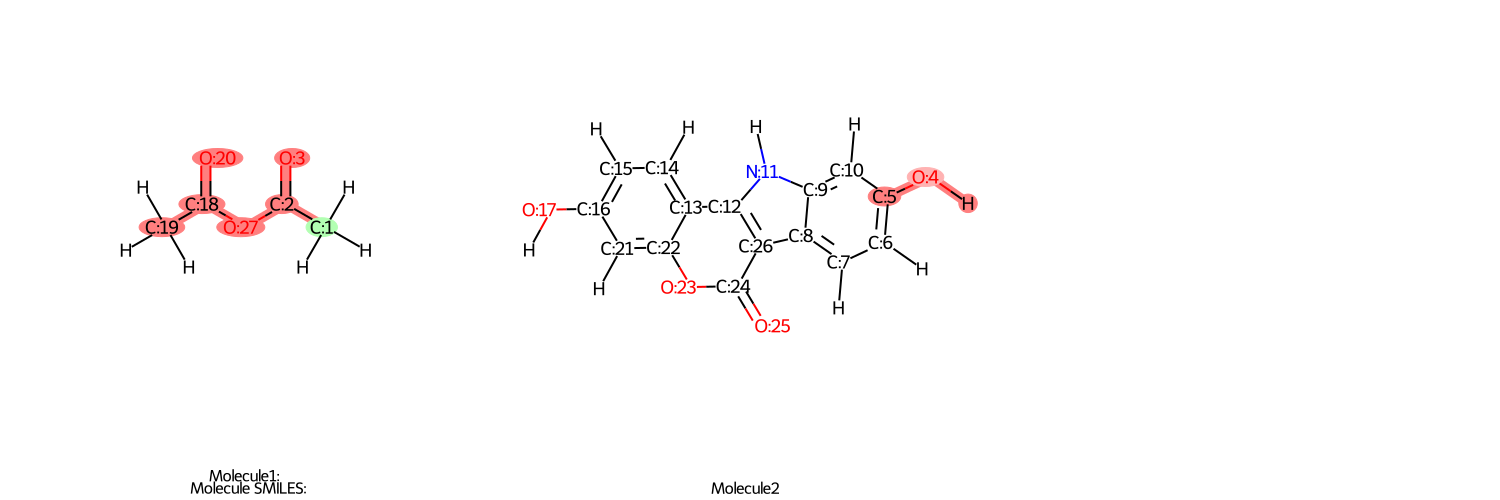

In [64]:

Draw.MolsToGridImage([Chem.AddHs(molfromsmiles('[CH3:1][C:2](=[O:3])[O:27][C:18]([CH3:19])=[O:20]')),Chem.AddHs(molfromsmiles('[OH:4][c:5]1[cH:6][cH:7][c:8]2[c:9]([cH:10]1)[nH:11][c:12]1[c:13]3[cH:14][cH:15][c:16]([OH:17])[cH:21][c:22]3[o:23][c:24](=[O:25])[c:26]21'))],highlightAtomLists=[[0, 1, 2, 3, 4, 5, 6],[20, 0, 1]],highlightAtomColors=[{0:(0.7,1,0.7)},{0:(1,0.7,0.7)}],useSVG=True,subImgSize=(500,500),legends=['Molecule1:\n \n\n\n Molecule SMILES:','Molecule2'])

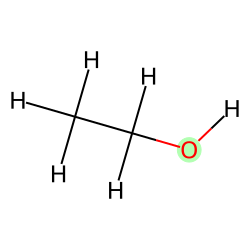

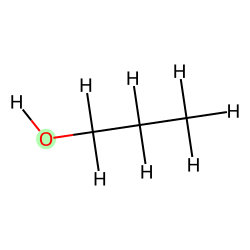

In [96]:
highlightsubstruct('CCO',pattlist=['O'],height=250,width=250)
highlightsubstruct('CCCO',pattlist=['O'],height=250,width=250)

In [93]:
[demodict[specid]['smiles'] for specid in demodict]

['Oc1ccc(O)cc1', 'O=C(O)c1ccccc1O']

In [92]:
demodict=IP['analoguerxnscent'].iloc[19].LHSdata

In [75]:
demdict={'Note':'<i>N</i>-(2-acetylamino-benzyl)-benzanilide'}

In [79]:
print(f"who: {demdict}")
display(Markdown(f"namedict: {demdict}"))
display(Markdown(f"Temperature (&deg;C)"))

who: {'Note': '<i>N</i>-(2-acetylamino-benzyl)-benzanilide'}


namedict: {'Note': '<i>N</i>-(2-acetylamino-benzyl)-benzanilide'}

Temperature (&deg;C)

In [80]:
# len(IP['analoguerxnsmapped'])
IP['analoguerxnsfinal'].iloc[0].LHSdata
{specid:IP['analoguerxnsfinal'].iloc[0].LHSdata[specid][key] for specid in IP['analoguerxnsfinal'].iloc[0].LHSdata for key in ['smiles','count']}
IP['analoguerxns'].dtypes
IP['analoguerxns'][:10]
IP['analoguerxns'].iloc[0].to_dict()

{385737: {'atomdict': {'C': 4, 'O': 3, 'H': 6},
  'charge': 0,
  'smiles': 'CC(=O)OC(C)=O',
  'formula': 'C4H6O3',
  'count': 1,
  'mixture': False,
  'mappedsmiles': ['[CH3:1][C:2](=[O:3])[O:27][C:18]([CH3:19])=[O:20]'],
  'cleanmol': [<rdkit.Chem.rdchem.Mol at 0x7fef78e25f90>],
  'querycompds': {'CC(=O)OC(C)=O': ['CC(=O)OC(C)=O']},
  'fragloc': {0: {'CC(=O)OC(C)=O': {'corrmatches': [(0, 1, 2, 3, 4, 5, 6)],
     'funcgroupids': [{1, 2, 3, 4, 6}]}}},
  'reacfrag': {0: {'CC(=O)OC(C)=O': [0]}}},
 4813977: {'atomdict': {'O': 4, 'C': 15, 'N': 1, 'H': 9},
  'charge': 0,
  'smiles': 'O=c1oc2cc(O)ccc2c2[nH]c3cc(O)ccc3c12',
  'formula': 'C15H9NO4',
  'count': 1,
  'mixture': False,
  'mappedsmiles': ['[OH:4][c:5]1[cH:6][cH:7][c:8]2[c:9]([cH:10]1)[nH:11][c:12]1[c:13]3[cH:14][cH:15][c:16]([OH:17])[cH:21][c:22]3[o:23][c:24](=[O:25])[c:26]21'],
  'cleanmol': [<rdkit.Chem.rdchem.Mol at 0x7fef613e8e00>],
  'querycompds': {'[H]Oc': ['CC(=O)Nc1ccc(O)cc1', 'Nc1ccc(O)cc1']},
  'fragloc': {0: {'[H]Oc': {

{385737: 1, 4813977: 1}

NumRefs             Int64
ReactantID         object
MissingReactant    object
ProductID          object
MissingProduct     object
NumSteps           object
NumStages           Int64
ReagentID          object
MissingReagent     object
Temperature        object
Pressure           object
ReactionTime       object
SolventID          object
MissingSolvent     object
CatalystID         object
MissingCatalyst    object
ConditionNotes     string
ReactionType       object
NameDict           object
YearPublished      object
Yield              object
dtype: object

,,NumRefs,ReactantID,MissingReactant,ProductID,MissingProduct,NumSteps,NumStages,ReagentID,MissingReagent,Temperature,...,ReactionTime,SolventID,MissingSolvent,CatalystID,MissingCatalyst,ConditionNotes,ReactionType,NameDict,YearPublished,Yield
ReactionID,Instance,,,,,,,,,,,,,,,,,,,,,
524491,0,1,[3496201],[],[3494311],[],1,1,[],[],[],...,[],[],[],[],[],bei der Acetylierung,[],"{3496201: '2,3,5-tris-benzylsulfanyl-hydroquin...",[1904],{}
560744,0,1,"[2524677, 385737]",[],[2532275],[],1,1,[],[],[],...,[],[],[],[],[],,[],"{2524677: '2-methoxy-5-methyl-4-nitro-phenol',...",[1927],{}
2361533,0,1,"[385737, 4813977]",[],[4824322],[],1,1,[],[],[],...,[1.5],[],[],[],[],Heating,[],"{385737: 'acetic anhydride', 4813977: '3,9-dih...",[1991],{4824322: 60.0}
4069769,0,1,"[1363961, 2090421]",[],[7137958],[],1,1,[],[],[],...,[],[1098229],[],[],[],Heating,[],"{1363961: '2,5-Dihydroxybenzaldehyde', 2090421...",[1994],{}
5099326,0,1,"[385737, 5904153]",[],[8252090],[],1,1,[],[],[],...,[],[103233],[],[],[],Ambient temperature,[],"{385737: 'acetic anhydride', 5904153: 'E-r2-vi...",[1999],{8252090: 96.7}
8209298,0,1,[385737],[3.3'-dinitro-4.4'-dioxy-benzil-osazone of mel...,[3528928],[],1,1,[],[],[],...,[],[],[],[],[],,[],"{385737: 'acetic anhydride', 3528928: '4,4'-di...",[1902],{}
9302695,0,1,"[1354736, 9411110]",[],[9459356],[],1,1,[],[],[20],...,[],[605365],[],[],[],,[],"{1354736: '1,2,3,4,11,11-hexachlorotricyclo&lt...",[2003],{}
23047280,0,1,"[11413134, 385737]",[],[11413129],[],1,1,[],[],[20],...,[22],[103233],[],[],[],,[],{11413134: '(Z)-1-[(tert-butoxy)carbonylamino]...,[2004],{}
23567554,0,1,"[385737, 7792579]",[],[14451996],[],1,1,[],[],[25],...,[3],[1730800],[],[],[],,[],"{385737: 'acetic anhydride', 7792579: 'daunofo...",[2004],{14451996: 83.0}


{'NumRefs': 1,
 'ReactantID': [3496201],
 'MissingReactant': [],
 'ProductID': [3494311],
 'MissingProduct': [],
 'NumSteps': 1,
 'NumStages': 1,
 'ReagentID': [],
 'MissingReagent': [],
 'Temperature': [],
 'Pressure': [],
 'ReactionTime': [],
 'SolventID': [],
 'MissingSolvent': [],
 'CatalystID': [],
 'MissingCatalyst': [],
 'ConditionNotes': 'bei der Acetylierung',
 'ReactionType': [],
 'NameDict': {3496201: '2,3,5-tris-benzylsulfanyl-hydroquinone',
  3494311: '1,4-diacetoxy-2,5-bis-benzylsulfanyl-benzene'},
 'YearPublished': [1904],
 'Yield': {}}

In [46]:
def took(**kwargs):
    print(kwargs)
    
took(**IP['analoguerxns'].iloc[0][['MissingCatalyst','NameDict']].to_dict())

{'MissingCatalyst': [], 'NameDict': {3496201: '2,3,5-tris-benzylsulfanyl-hydroquinone', 3494311: '1,4-diacetoxy-2,5-bis-benzylsulfanyl-benzene'}}


**Output**

In [18]:
IP=main('Case2',steps=[5,6,7,8],**IP)

2022-08-24 09:51:53,251	INFO services.py:1171 -- View the Ray dashboard at http://127.0.0.1:8265


55.34% reactions remaining after cleaning


2022-08-24 09:54:42,036	INFO services.py:1171 -- View the Ray dashboard at http://127.0.0.1:8265


Step 5 complete


2022-08-24 09:58:03,129	INFO services.py:1171 -- View the Ray dashboard at http://127.0.0.1:8265


Step 6 complete


2022-08-24 10:40:39,875	INFO services.py:1171 -- View the Ray dashboard at http://127.0.0.1:8266
2022-08-24 11:09:51,611	INFO services.py:1171 -- View the Ray dashboard at http://127.0.0.1:8265
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
2022-08-24 11:11:48,216	INFO services.py:1171 -- View the Ray dashboard at http://127.0.0.1:8265
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
2022-08-24 11:12:30,008	INFO services.py:1171 -- View the Ray dashboard at http://127.0.0.1:8265


Step 7 complete


2022-08-24 11:14:18,935	INFO services.py:1171 -- View the Ray dashboard at http://127.0.0.1:8265
2022-08-24 11:16:57,983	INFO services.py:1171 -- View the Ray dashboard at http://127.0.0.1:8265


Step 8 complete


The above steps can be completed in roughly 1.5 hours for this case study (>238000 reactions). Visualization of this stage is shown below.

## Impurity prediction (Steps 9 - 11)

In [61]:
IP['analoguerxnstempl']=None
IP['analoguerxnstemplfilt']=None
IP['analoguerxnsimp']=None
IP['analoguerxnsimpfilt']=None
IP['impfinal']=None
IP['impfinalfilt']=None

In [62]:
IP=main('Case2',steps=[9,10,11],**IP)

2022-08-24 17:57:38,488	INFO services.py:1171 -- View the Ray dashboard at http://127.0.0.1:8265


Step 9 complete


2022-08-24 17:58:25,991	INFO services.py:1171 -- View the Ray dashboard at http://127.0.0.1:8265
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Step 10 complete
Step 11 complete


The impurity prediction module takes roughly 2-3 minutes

In [23]:
demo5=pd.read_pickle('/home/aa2133/Impurity-Project/Input/Case2.4/ImpurityPrediction/impfinalfilt.pickle')

In [24]:
demo5

querycompds  \
ReactionID Instance                                        
45775818   0         (CC(=O)OC(C)=O, CC(=O)Nc1ccc(O)cc1)   
           0               (CC(=O)OC(C)=O, Nc1ccc(O)cc1)   
3929066    0                     (CC(=O)O, Nc1ccc(O)cc1)   
2355947    0         (CC(=O)OC(C)=O, CC(=O)Nc1ccc(O)cc1)   
           0               (CC(=O)OC(C)=O, Nc1ccc(O)cc1)   
...                                                  ...   
24003435   1                     (CC(=O)O, Nc1ccc(O)cc1)   
41385745   0                     (CC(=O)O, Nc1ccc(O)cc1)   
25192678   0                     (CC(=O)O, Nc1ccc(O)cc1)   
24588106   0                     (CC(=O)O, Nc1ccc(O)cc1)   
25337533   0                     (Nc1ccc(O)cc1, CC(=O)O)   

                                              impurities  \
ReactionID Instance                                        
45775818   0         (CC(=O)O, CC(=O)Nc1ccc(OC(C)=O)cc1)   
           0               (CC(=O)O, CC(=O)Oc1ccc(N)cc1)   
3929066    0                     (CC(=O)Nc1ccc(O)cc1, O)   
2355947    0         (CC(=O)O, CC(=O)Nc1ccc(OC(C)=O)cc1)   
           0               (CC(=O)O, CC(=O)Oc1ccc(N)cc1)   
...                                                  ...   
24003435   1                     (CC(=O)Nc1ccc(O)cc1, O)   
41385745   0                     (CC(=O)Nc1ccc(O)cc1, O)   
25192678   0                     (CC(=O)Nc1ccc(O)cc1, O)   
24588106   0                     (CC(=O)Nc1ccc(O)cc1, O)   
25337533   0                     (CC(=O)Nc1ccc(O)cc1, O)   

                                                           impurityrxn  \
ReactionID Instance                                                      
45775818   0         CC(=O)OC(C)=O.CC(=O)Nc1ccc(O)cc1>>CC(=O)O.CC(=...   
           0         CC(=O)OC(C)=O.Nc1ccc(O)cc1>>CC(=O)O.CC(=O)Oc1c...   
3929066    0                CC(=O)O.Nc1ccc(O)cc1>>CC(=O)Nc1ccc(O)cc1.O   
2355947    0         CC(=O)OC(C)=O.CC(=O)Nc1ccc(O)cc1>>CC(=O)O.CC(=...   
           0         CC(=O)OC(C)=O.Nc1ccc(O)cc1>>CC(=O)O.CC(=O)Oc1c...   
...                                                                ...   
24003435   1                CC(=O)O.Nc1ccc(O)cc1>>CC(=O)Nc1ccc(O)cc1.O   
41385745   0                CC(=O)O.Nc1ccc(O)cc1>>CC(=O)Nc1ccc(O)cc1.O   
25192678   0                CC(=O)O.Nc1ccc(O)cc1>>CC(=O)Nc1ccc(O)cc1.O   
24588106   0                CC(=O)O.Nc1ccc(O)cc1>>CC(=O)Nc1ccc(O)cc1.O   
25337533   0                Nc1ccc(O)cc1.CC(=O)O>>CC(=O)Nc1ccc(O)cc1.O   

                                                              template   msg4  \
ReactionID Instance                                                             
45775818   0         [C:1][C;H0;D3;+0:2](=[O;H0;D1;+0:3])[O;H0;D2;+...  Valid   
           0         [C:1][C;H0;D3;+0:2](=[O;H0;D1;+0:3])[O;H0;D2;+...  Valid   
3929066    0         [C;H0;D3;+0:9](=[O;H0;D1;+0:10])([C:11])[OH;D1...  Valid   
2355947    0         [C:1][C;H0;D3;+0:2](=[O;H0;D1;+0:3])[O;H0;D2;+...  Valid   
           0         [C:1][C;H0;D3;+0:2](=[O;H0;D1;+0:3])[O;H0;D2;+...  Valid   
...                                                                ...    ...   
24003435   1         [C;H0;D3;+0:13]([C:14])(=[O;H0;D1;+0:15])[OH;D...  Valid   
41385745   0         [C:1][C;H0;D3;+0:2](=[O;H0;D1;+0:3])[OH;D1;+0:...  Valid   
25192678   0         [C;H0;D3;+0:11]([C:12])(=[O;H0;D1;+0:13])[OH;D...  Valid   
24588106   0         [C;H0;D3;+0:19]([C:20])(=[O;H0;D1;+0:21])[OH;D...  Valid   
25337533   0         [c:20][NH2;D1;+0:21].[OH;D1;+0:1][C;H0;D3;+0:2...  Valid   

                    rxncentermapnum  \
ReactionID Instance                   
45775818   0            {32, 4, 31}   
           0            {32, 4, 31}   
3929066    0             {8, 9, 23}   
2355947    0             {9, 10, 4}   
           0             {9, 10, 4}   
...                             ...   
24003435   1           {16, 12, 13}   
41385745   0             {2, 4, 31}   
25192678   0           {18, 10, 11}   
24588106   0           {18, 19, 29}  

In [65]:
set(demo5.index)==set(IP['impfinalfilt'].index)

True

In [66]:
IP['analoguerxns_updated']

,,ReactantID,ProductID,NumRefs,NumSteps,NumStages,ReagentID,SolventID,Rdata,Pdata,Rgtdata,Solvdata,hc_prod,hc_react
ReactionID,Instance,,,,,,,,,,,,,
2361533,0,"[385737, 4813977]",[4824322],1,1,1,[],[],"{385737: {'atomdict': {'C': 4, 'O': 3, 'H': 6}...","{4824322: {'atomdict': {'C': 19, 'O': 6, 'N': ...",{},{},"{0: {'atomdict': {'C': 2, 'O': 2, 'H': 4}, 'ch...","{1: {'atomdict': {'O': 1, 'H': 2}, 'charge': 0..."
4069769,0,"[1363961, 2090421]",[7137958],1,1,1,[],[1098229],"{1363961: {'atomdict': {'O': 3, 'C': 7, 'H': 6...","{7137958: {'atomdict': {'O': 5, 'C': 14, 'N': ...",{},"{1098229: {'atomdict': {'C': 1, 'O': 1, 'H': 4...","{0: {'atomdict': {'C': 2, 'O': 2, 'H': 4}, 'ch...","{1: {'atomdict': {'O': 1, 'H': 2}, 'charge': 0..."
5099326,0,"[385737, 5904153]",[8252090],1,1,1,[],[103233],"{385737: {'atomdict': {'C': 4, 'O': 3, 'H': 6}...","{8252090: {'atomdict': {'C': 76, 'O': 22, 'H':...",{},"{103233: {'atomdict': {'C': 5, 'N': 1, 'H': 5}...","{0: {'atomdict': {'C': 2, 'O': 2, 'H': 4}, 'ch...","{1: {'atomdict': {'O': 1, 'H': 2}, 'charge': 0..."
9302695,0,"[1354736, 9411110]",[9459356],1,1,1,[],[605365],"{1354736: {'atomdict': {'O': 3, 'C': 13, 'Cl':...","{9459356: {'atomdict': {'O': 6, 'C': 27, 'N': ...",{},"{605365: {'atomdict': {'C': 3, 'N': 1, 'O': 1,...","{0: {'atomdict': {'C': 2, 'O': 2, 'H': 4}, 'ch...","{1: {'atomdict': {'O': 1, 'H': 2}, 'charge': 0..."
23047280,0,"[11413134, 385737]",[11413129],1,1,1,[],[103233],"{385737: {'atomdict': {'C': 4, 'O': 3, 'H': 6}...","{11413129: {'atomdict': {'C': 12, 'O': 6, 'N':...",{},"{103233: {'atomdict': {'C': 5, 'N': 1, 'H': 5}...","{0: {'atomdict': {'C': 2, 'O': 2, 'H': 4}, 'ch...","{1: {'atomdict': {'O': 1, 'H': 2}, 'charge': 0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42053213,0,[29220775],[28087954],1,1,1,[742035],[],"{29220775: {'atomdict': {'C': 44, 'O': 15, 'N'...","{28087954: {'atomdict': {'O': 15, 'C': 36, 'N'...","{742035: {'atomdict': {'O': 2, 'C': 2, 'F': 3,...",{},"{0: {'atomdict': {'C': 2, 'O': 2, 'H': 4}, 'ch...","{1: {'atomdict': {'O': 1, 'H': 2}, 'charge': 0..."
250301,0,[1783431],"[1209322, 1732479]",1,1,1,[],[],"{1783431: {'atomdict': {'N': 2, 'C': 4, 'O': 5...","{1209322: {'atomdict': {'O': 3, 'C': 2, 'H': 4...",{},{},"{0: {'atomdict': {'C': 2, 'O': 2, 'H': 4}, 'ch...","{1: {'atomdict': {'O': 1, 'H': 2}, 'charge': 0..."
45238323,0,"[26679168, 742035]",[31137409],1,1,1,[],[1730800],"{26679168: {'atomdict': {'C': 11, 'O': 5, 'N':...","{31137409: {'atomdict': {'C': 8, 'O': 5, 'N': ...",{},"{1730800: {'atomdict': {'Cl': 2, 'C': 1, 'H': ...","{0: {'atomdict': {'C': 2, 'O': 2, 'H': 4}, 'ch...","{1: {'atomdict': {'O': 1, 'H': 2}, 'charge': 0..."


## Impurity ranking (Steps 12 - 14)

In [24]:
from MainFunctions import writepickle,openpickle,initray

In [25]:
IP=openpickle('/home/aa2133/Impurity-Project/Input/Case2.4/combineddict.pickle')

In [26]:
fragdb=IP['fragdbsource']

In [8]:
writepickle(IP,'/home/aa2133/Impurity-Project/Input/Case2.4/','combineddict')

In [6]:
IP=main('Case2',steps=[12,13,14],**IP)

2022-08-29 10:23:16,678	INFO services.py:1171 -- View the Ray dashboard at http://127.0.0.1:8265
2022-08-29 10:23:43,652	INFO services.py:1171 -- View the Ray dashboard at http://127.0.0.1:8265


Step 12 complete
Step 13 complete


2022-08-29 10:24:38,131	INFO services.py:1171 -- View the Ray dashboard at http://127.0.0.1:8265
2022-08-29 10:25:26,105	INFO services.py:1171 -- View the Ray dashboard at http://127.0.0.1:8265
To request implementation, send an email to feature_requests@modin.org.


Only 60.0% have temperature records (main reaction)
Only 60.0% have temperature records (impurity)
Only 70.0% have temperature records (impurity)
Only 50.0% have temperature records (impurity)
Only 50.0% have temperature records (impurity)
Only 60.0% have temperature records (impurity)
Only 30.0% have temperature records (impurity)
Only 0.0% have temperature records (impurity)
Only 40.0% have temperature records (impurity)
Only 40.0% have temperature records (impurity)
Only 40.0% have temperature records (impurity)
Only 20.0% have temperature records (impurity)
Only 100.0% have temperature records (impurity)
Only 0.0% have temperature records (impurity)
Only 0.0% have temperature records (impurity)
Only 0.0% have temperature records (impurity)
Only 0.0% have temperature records (impurity)
Only 0.0% have temperature records (impurity)
Only 100.0% have temperature records (impurity)
Only 90.0% have temperature records (impurity)
Only 10.0% have temperature records (impurity)
Only 0.0% ha

Query reaction (user input):


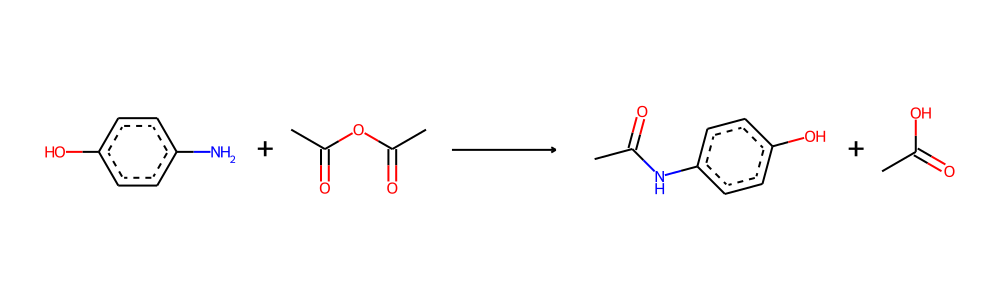

Temperature range (C) of 1.0 to 64.0


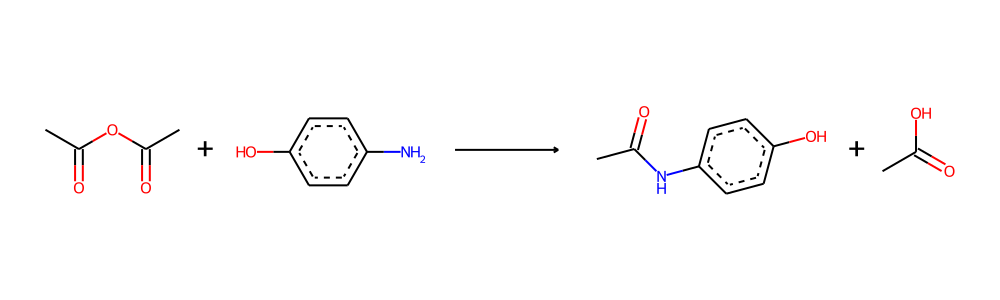

Max relevance: 1.0
Smarts: CC(=O)OC(C)=O.Nc1ccc(O)cc1>>CC(=O)Nc1ccc(O)cc1.CC(=O)O
Number of hits: 12180
Temperature range (10th to 90th %tile): 1.0-64.0
Analogue reactions with max relevance:
Reaction ID: 570100
Instance: 26
Relevance: 1.0


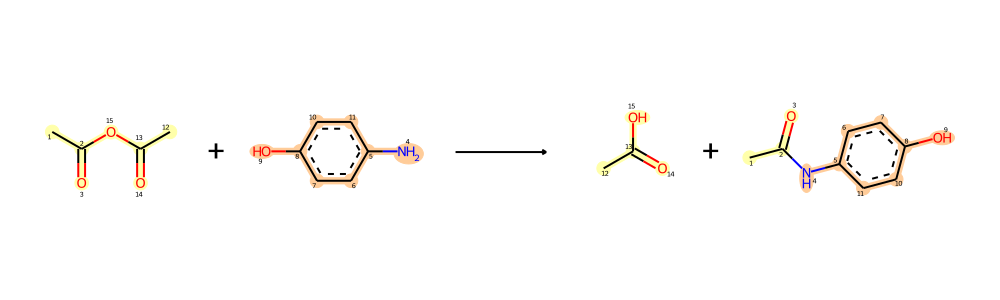

Reagents: 
Catalyst: 
Solvents: tetrahydrofuran
Temperature (C): 0 - 60
Condition notes: 
Analogue reactions with max relevance:
Reaction ID: 570100
Instance: 26
Relevance: 1.0


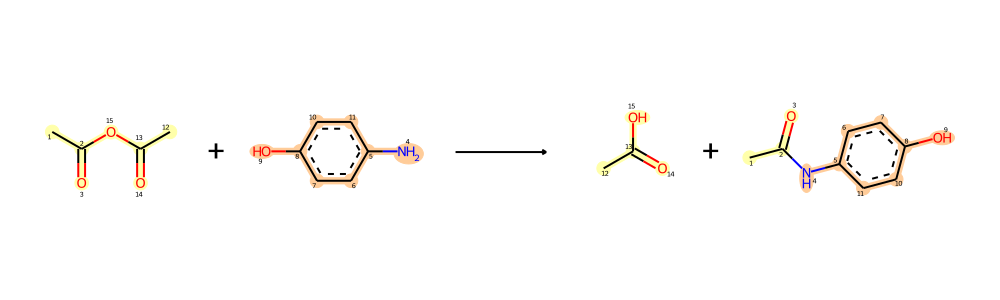

Reagents: 
Catalyst: 
Solvents: tetrahydrofuran
Temperature (C): 0 - 60
Condition notes: 


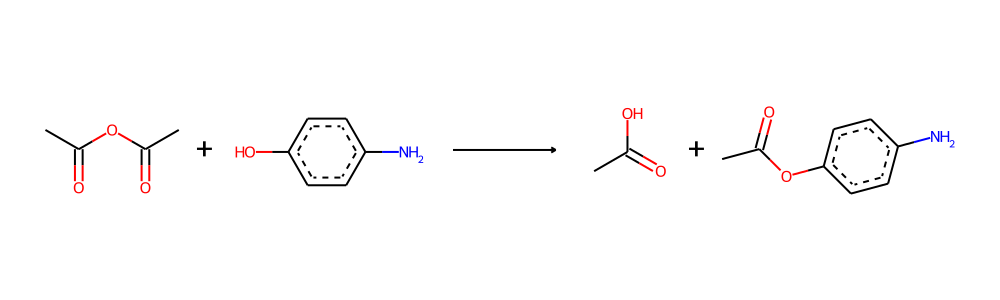

Max relevance: 0.91
Smarts: CC(=O)OC(C)=O.Nc1ccc(O)cc1>>CC(=O)O.CC(=O)Oc1ccc(N)cc1
Number of hits: 830
Temperature range (10th to 90th %tile): 21.0-125.0
Analogue reactions with max relevance:
Reaction ID: 2380306
Instance: 6
Relevance: 0.91


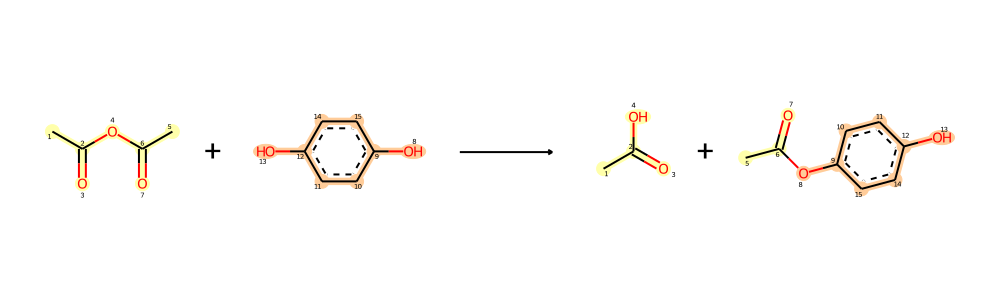

Reagents: acetic acid
Catalyst: 
Solvents: 
Temperature (C): 20
Condition notes: Ambient temperature
Analogue reactions with max relevance:
Reaction ID: 555508
Instance: 1
Relevance: 0.86


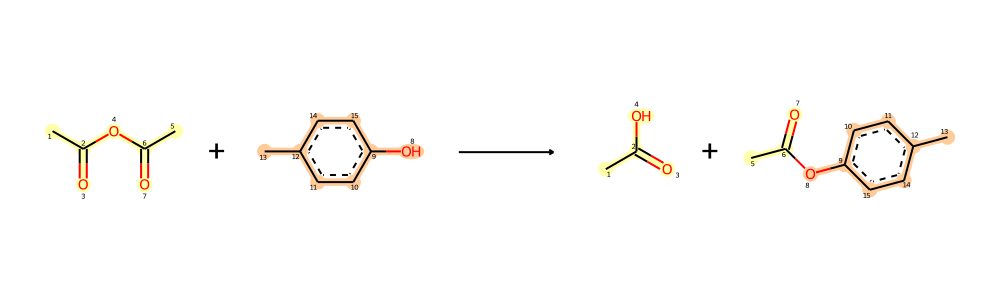

Reagents: 
Catalyst: 
Solvents: 
Temperature (C): 20
Condition notes: 
Removed analogue reactions with max relevance:
Reaction ID: 4167426
Instance: 6
Relevance: 1.0
Reaction removed due to: Invalid catalyst


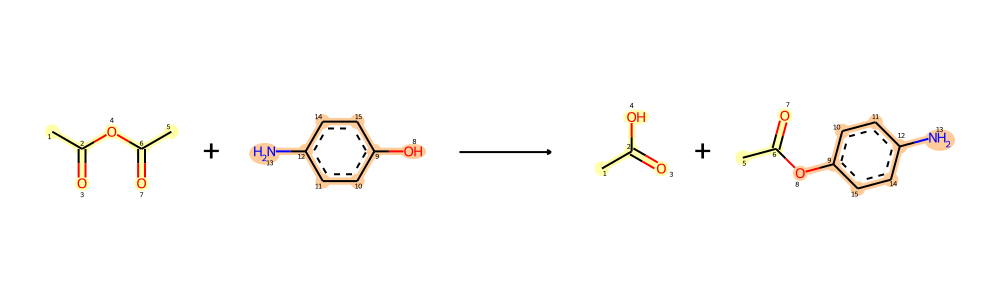

Reagents: 
Catalyst: CoCl<sub>2</sub>
Solvents: acetonitrile
Temperature (C): 20
Condition notes: Ambient temperature


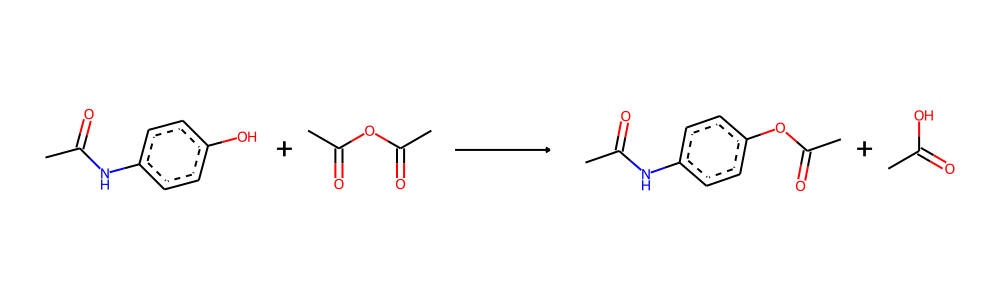

Max relevance: 0.87
Smarts: CC(=O)Nc1ccc(O)cc1.CC(=O)OC(C)=O>>CC(=O)Nc1ccc(OC(C)=O)cc1.CC(=O)O
Number of hits: 830
Temperature range (10th to 90th %tile): 20.0-127.0
Analogue reactions with max relevance:
Reaction ID: 2380306
Instance: 6
Relevance: 0.87


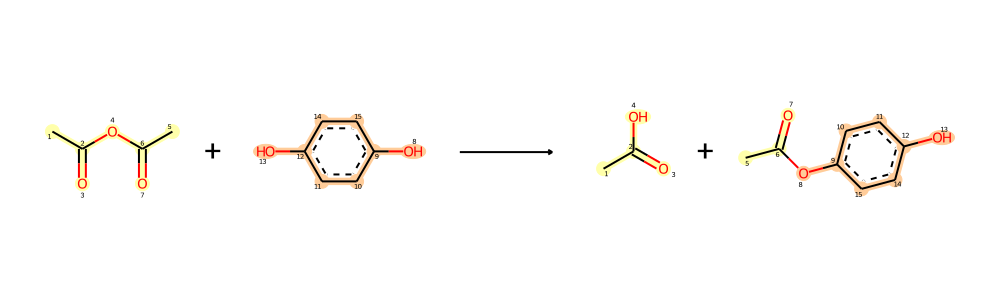

Reagents: acetic acid
Catalyst: 
Solvents: 
Temperature (C): 20
Condition notes: Ambient temperature
Analogue reactions with max relevance:
Reaction ID: 572424
Instance: 18
Relevance: 0.83


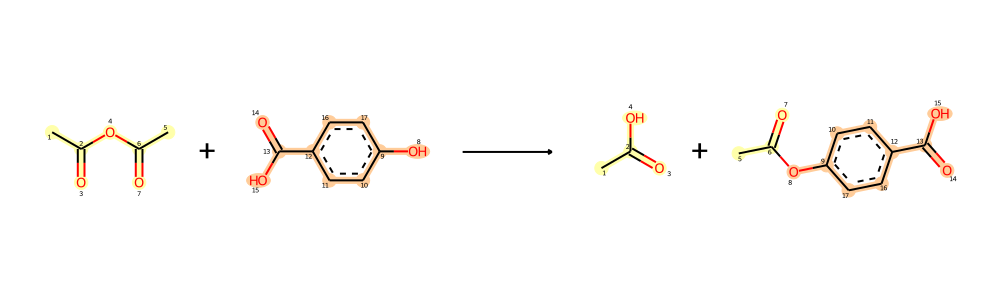

Reagents: 
Catalyst: 
Solvents: water monomer
Temperature (C): 20 - 80
Condition notes: 
Removed analogue reactions with max relevance:
Reaction ID: 4775026
Instance: 6
Relevance: 1.0
Reaction removed due to: Invalid condition


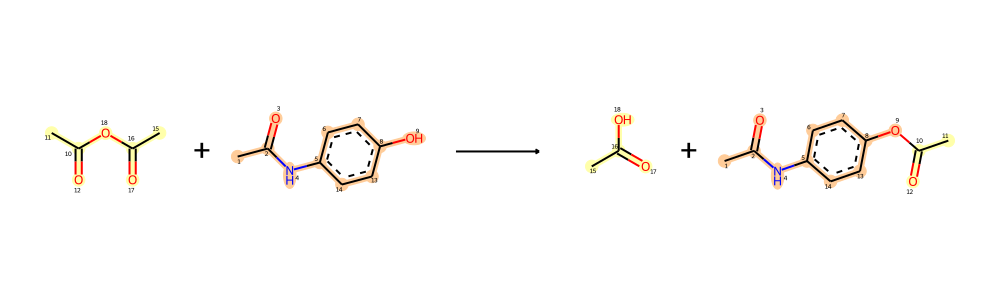

Reagents: 
Catalyst: 
Solvents: neat (no solvent)
Condition notes: Molecular sieve, Microwave irradiation, Green chemistry
Removed analogue reactions with max relevance:
Reaction ID: 571990
Instance: 18
Relevance: 0.91
Reaction removed due to: Missing temperature


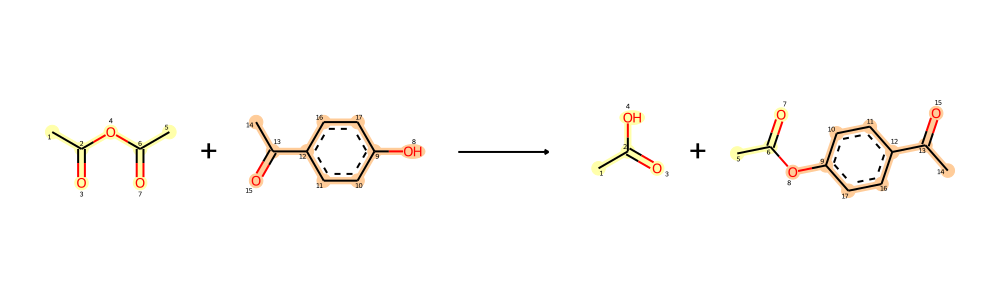

Reagents: acetic acid
Catalyst: 
Solvents: 
Condition notes: 


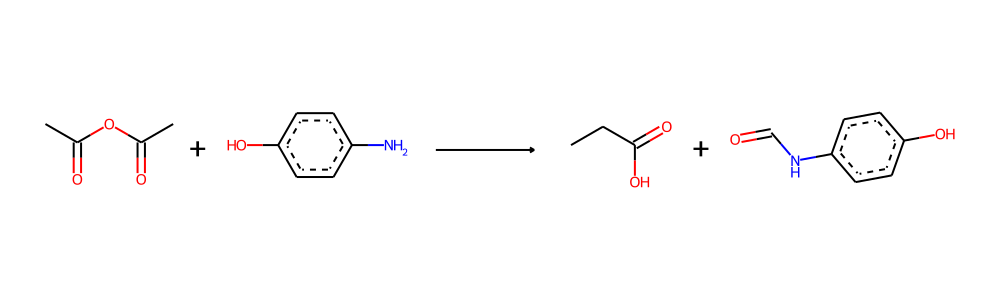

Max relevance: 0.73
Smarts: CC(=O)OC(C)=O.Nc1ccc(O)cc1>>CCC(=O)O.O=CNc1ccc(O)cc1
Number of hits: 257
Temperature range (10th to 90th %tile): 21.0-68.0
Analogue reactions with max relevance:
Reaction ID: 23857694
Instance: 1
Relevance: 0.73


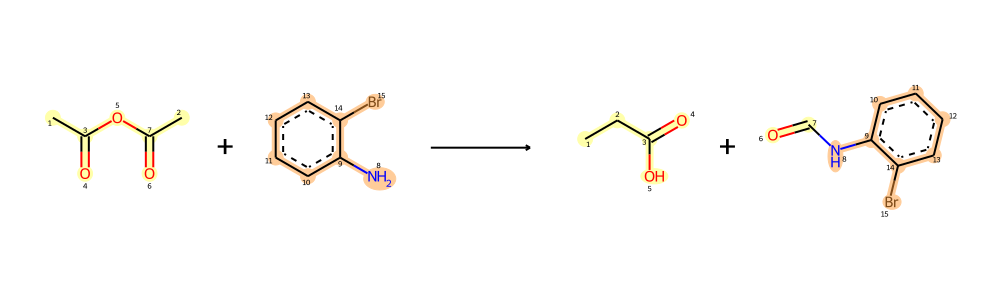

Reagents: 
Catalyst: 
Solvents: tetrahydrofuran
Temperature (C): 20 - 70
Condition notes: 
Analogue reactions with max relevance:
Reaction ID: 23857694
Instance: 1
Relevance: 0.73


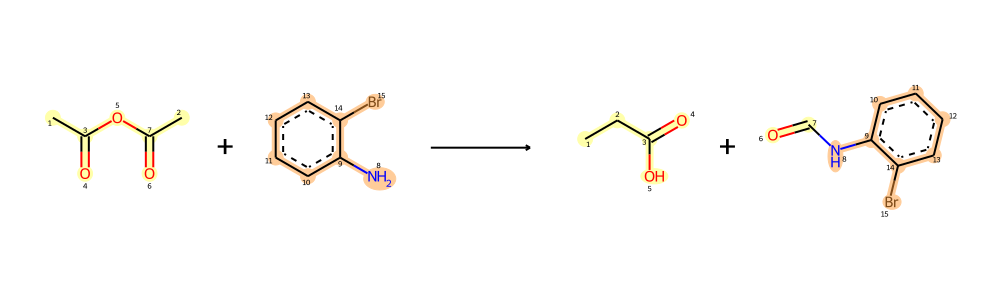

Reagents: 
Catalyst: 
Solvents: tetrahydrofuran
Temperature (C): 20 - 70
Condition notes: 


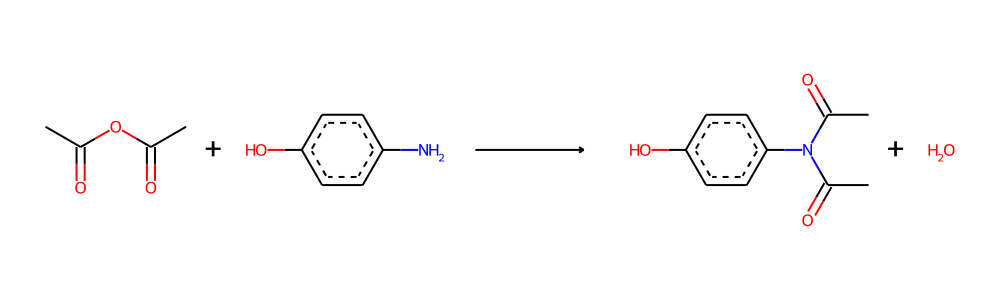

Max relevance: 0.73
Smarts: CC(=O)OC(C)=O.Nc1ccc(O)cc1>>CC(=O)N(C(C)=O)c1ccc(O)cc1.O
Number of hits: 173
Temperature range (10th to 90th %tile): 45.0-217.0
Analogue reactions with max relevance:
Reaction ID: 39599319
Instance: 0
Relevance: 0.73


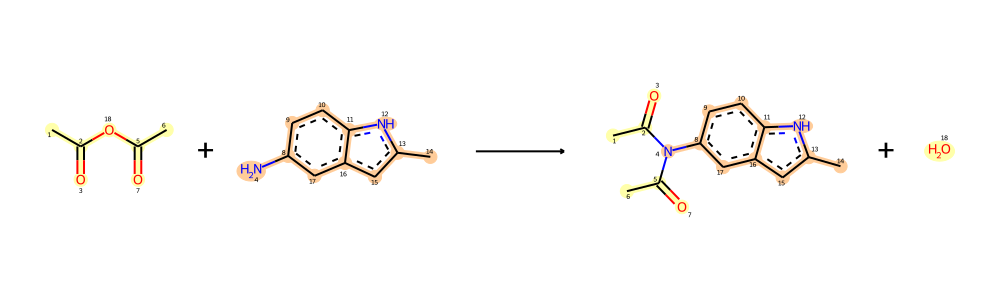

Reagents: 
Catalyst: 
Solvents: 
Temperature (C): 60
Condition notes: Inert atmosphere
Analogue reactions with max relevance:
Reaction ID: 38580543
Instance: 0
Relevance: 0.69


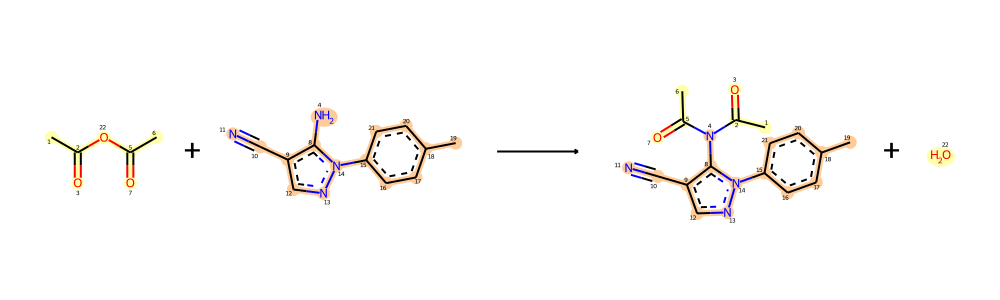

Reagents: 
Catalyst: 
Solvents: 
Temperature (C): 20
Condition notes: 
Removed analogue reactions with max relevance:
Reaction ID: 25528445
Instance: 0
Relevance: 0.83
Reaction removed due to: Missing temperature


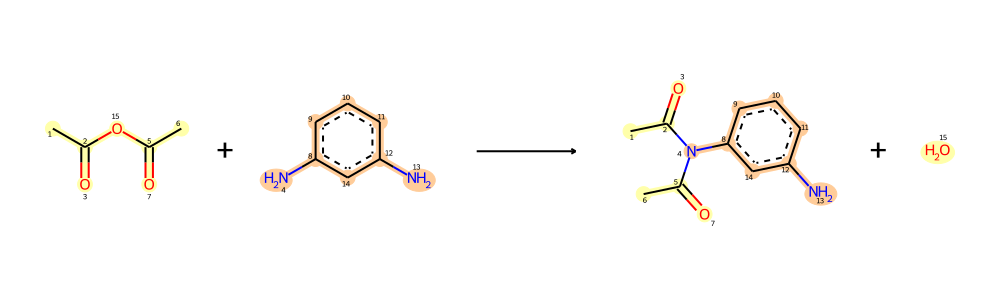

Reagents: acetic acid
Catalyst: 
Solvents: water
Condition notes: 
Removed analogue reactions with max relevance:
Reaction ID: 571094
Instance: 0
Relevance: 0.83
Reaction removed due to: Temperature outside indicated range


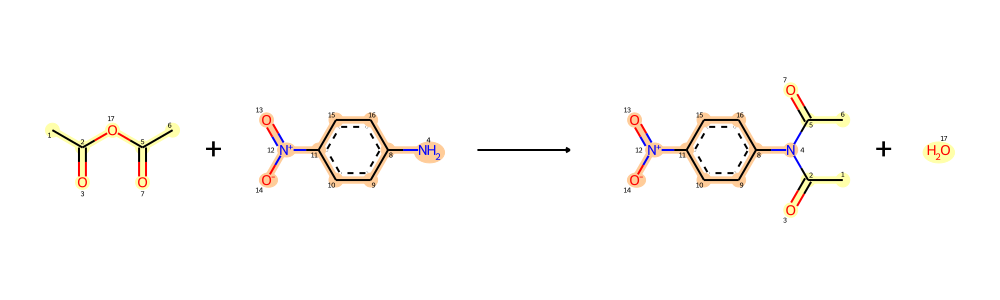

Reagents: 
Catalyst: 
Solvents: 
Temperature (C): 200
Condition notes: im Druckrohr


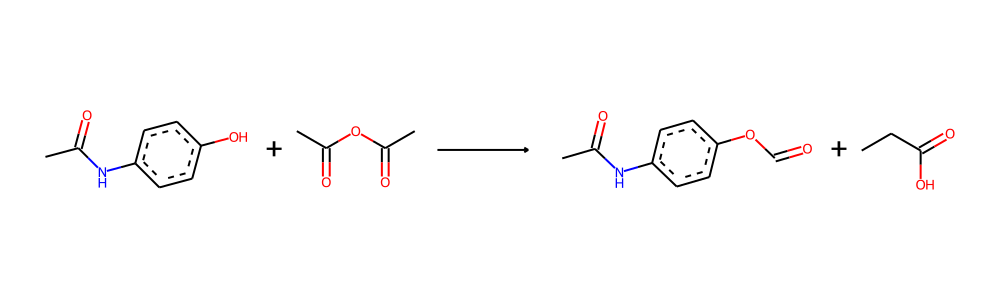

Max relevance: 0.59
Smarts: CC(=O)Nc1ccc(O)cc1.CC(=O)OC(C)=O>>CC(=O)Nc1ccc(OC=O)cc1.CCC(=O)O
Number of hits: 2
Temperature range (10th to 90th %tile): 20.0-20.0
Analogue reactions with max relevance:
Reaction ID: 25683884
Instance: 0
Relevance: 0.59


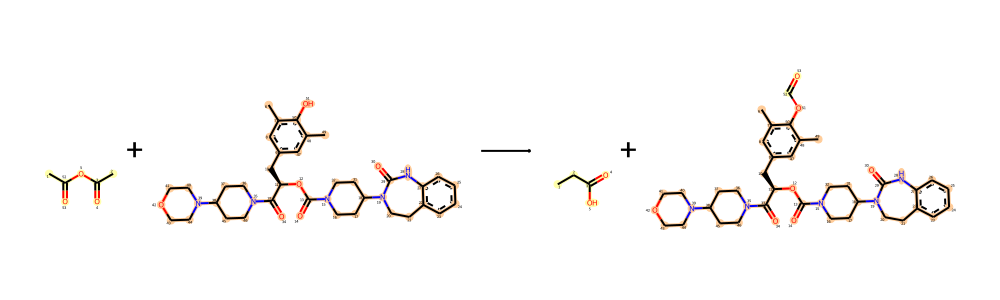

Reagents: 
Catalyst: 
Solvents: dichloromethane, dichloromethane
Temperature (C): 20
Condition notes: 
Analogue reactions with max relevance:
Reaction ID: 25683884
Instance: 0
Relevance: 0.59


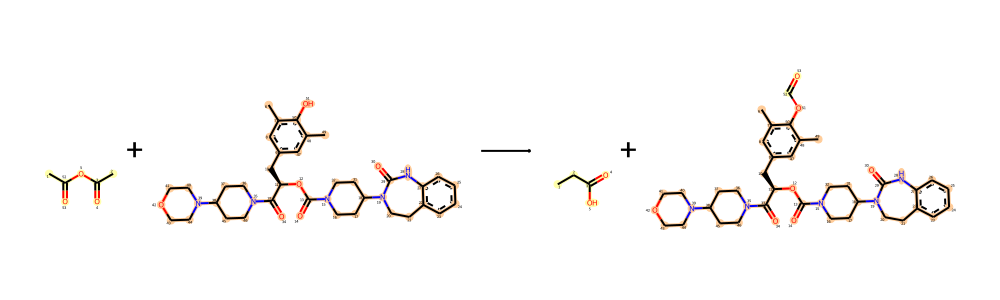

Reagents: 
Catalyst: 
Solvents: dichloromethane, dichloromethane
Temperature (C): 20
Condition notes: 


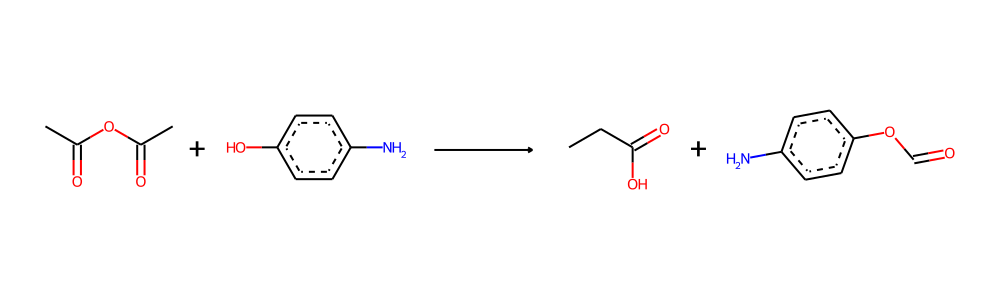

Max relevance: 0.56
Smarts: CC(=O)OC(C)=O.Nc1ccc(O)cc1>>CCC(=O)O.Nc1ccc(OC=O)cc1
Number of hits: 2
Temperature range (10th to 90th %tile): 20.0-20.0
Analogue reactions with max relevance:
Reaction ID: 25683884
Instance: 0
Relevance: 0.56


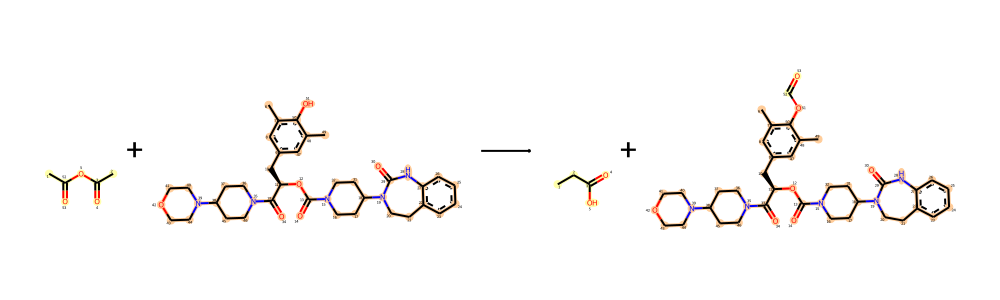

Reagents: 
Catalyst: 
Solvents: dichloromethane, dichloromethane
Temperature (C): 20
Condition notes: 
Analogue reactions with max relevance:
Reaction ID: 25683884
Instance: 0
Relevance: 0.56


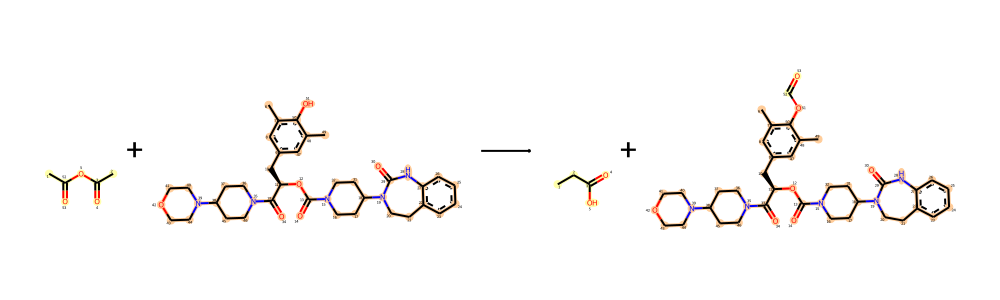

Reagents: 
Catalyst: 
Solvents: dichloromethane, dichloromethane
Temperature (C): 20
Condition notes: 


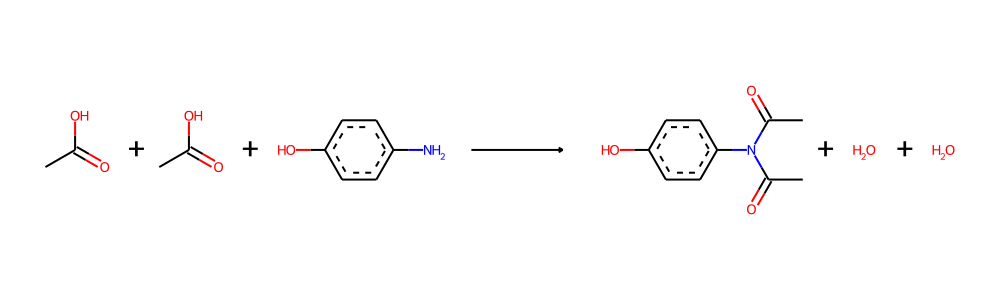

Max relevance: 0.44
Smarts: CC(=O)O.CC(=O)O.Nc1ccc(O)cc1>>CC(=O)N(C(C)=O)c1ccc(O)cc1.O.O
Number of hits: 6
Temperature range (10th to 90th %tile): 20.0-25.0
Analogue reactions with max relevance:
Reaction ID: 43891684
Instance: 0
Relevance: 0.44


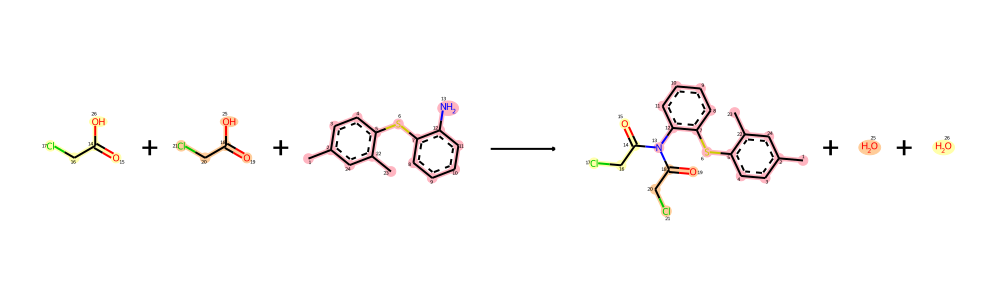

Reagents: 
Catalyst: 
Solvents: tetrahydrofuran
Temperature (C): 20 - 25
Condition notes: 
Analogue reactions with max relevance:
Reaction ID: 43891684
Instance: 0
Relevance: 0.44


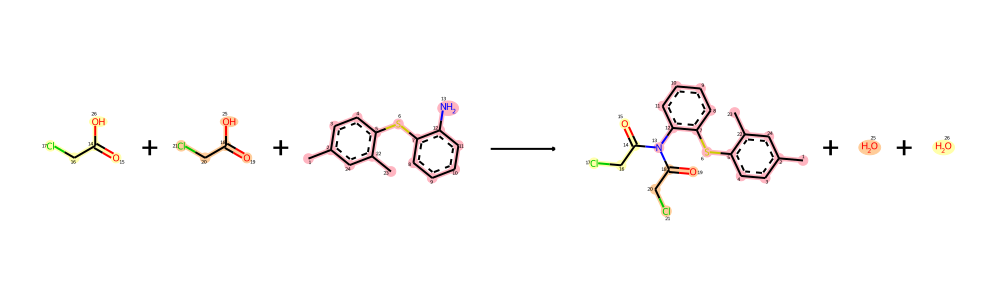

Reagents: 
Catalyst: 
Solvents: tetrahydrofuran
Temperature (C): 20 - 25
Condition notes: 


In [7]:
IP=main('Case2',steps=[15],**IP)

The impurity ranking module takes 4-5 minutes to complete

In [63]:
from Visualize import visfragment1

In [66]:
from AnalgCompds import getCarrierFrags0

In [78]:
pattlist=getCarrierFrags0('ClC1=CN=C(NC=C2I)C2=N1',resFormat='smiles',expand=2)
pattlist

['cc(n)Cl', '[H]c(c)nc(c)n', '[H]c1ccc(n)n1[H]', 'cc(c)I', 'cc(Cl)nc(c)c']

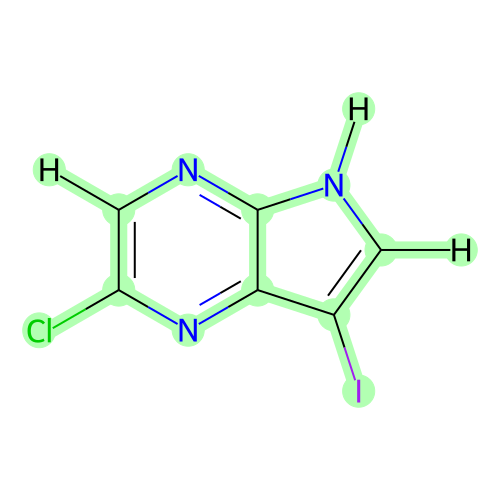

In [76]:
visfragment1('ClC1=CN=C(NC=C2I)C2=N1',pattlist=pattlist)

# Sandbox (to be deleted)

In [176]:
from cProfile import label
from collections import Counter
from typing import Dict, List, Union
import ipywidgets as widgets
from ipywidgets import interact, Label
import pandas as pd
from tables import Description
from AnalgCompds import getCarrierFrags0
from MainFunctions import (
    CustomError,
    drawMol,
    drawReaction,
    getfragments,
    highlightsubstruct,
    molfromsmiles,
)
from rdkit import Chem  # Importing RDKit
from rdkit.Chem import rdChemReactions, Draw  # Reaction processing
from IPython.display import display, Markdown, clear_output
import functools
from FunctionsDB import getmixturefrags
from MapRxns import checkrxnrow, maprxn, updaterxns_
from BalanceRxns import balancerxn
from RxnCenter import getrxncenterrow, validrxncenterrow

from helpCompound import hc_Dict
from AnalgRxns import getspecdat_rxn


def balance_rxn_dp(rxn: str, **kwargs):
    """_summary_

    Args:
        rxn (str): _description_

    Returns:
        _type_: _description_
    """
    IP = {
        "reagents": [],  # Only if one reaction is inputted
        "solvents": [],  # Only if one reaction is inputted
        "coefflim": 6,  # Maximum tolerable stoichiometric coefficient
        "usemapper": True,  # If mapper needs to be used
        "addrctonly": False,  # If only reactants should be included for balancing
        "ignoreH": False,  # If hydrogens are to be ignored when balancing
        "hc_prod": hc_Dict,  # Help compound dictionary,
        "coefflim": 6,
        "hc_react": None,
        "first": False,
    }  # Help reactant dictionary
    IP = {**IP, **kwargs}
    Rdata, Pdata, Rgtdata, Solvdata = getspecdat_rxn(
        rxn, reagents=IP["reagents"], solvents=IP["solvents"]
    )
    IP["addedspecies"] = [i for i in Rdata]
    rxnsmiles0 = ">>".join(
        [
            getfragments([Rdata[r]["smiles"] for r in Rdata], smiles=True),
            getfragments([Pdata[p]["smiles"] for p in Pdata], smiles=True),
        ]
    )
    IP["rxnsmiles0"] = rxnsmiles0
    input = {
        key: IP[key]
        for key in [
            "rxnsmiles0",
            "first",
            "usemapper",
            "addedspecies",
            "hc_prod",
            "hc_react",
            "coefflim",
            "addrctonly",
            "ignoreH",
        ]
        if key in IP
    }

    (
        rxnsmiles0,
        balrxnsmiles,
        msg,
        LHSids,
        RHSids,
        hcrct,
        hcprod,
        LHSdata,
        RHSdata,
    ) = balancerxn(
        Rdata,
        Pdata,
        Rgtdata=Rgtdata,
        Solvdata=Solvdata,
        **input,
    )
    mappedrxn, conf = maprxn([balrxnsmiles])
    if mappedrxn != "Error":
        rseries = pd.DataFrame(
            [{"mapped_rxn": mappedrxn, "Rdata": LHSdata, "Pdata": RHSdata, "msg": msg}]
        ).iloc[0]
        LHSdata, RHSdata, msg1 = checkrxnrow(rseries)
        if "Unmapped" in msg1 or "unmapped" in msg1:
            (
                mappedrxn,
                conf,
                balrxnsmiles,
                msg,
                LHSids,
                RHSids,
                hcrct,
                hcprod,
                LHSdata,
                RHSdata,
                msg1,
            ) = updaterxns_(
                pd.DataFrame(
                    [
                        {
                            "Rdata": Rdata,
                            "LHSdata": LHSdata,
                            "RHSdata": RHSdata,
                            "msg": msg,
                            "hcprod": hcprod,
                            "hcrct": hcrct,
                            "Rgtdata": Rgtdata,
                            "Solvdata": Solvdata,
                        }
                    ]
                ).iloc[0]
            )
    else:
        msg1 = "Mapping error"
    return (
        rxnsmiles0,
        balrxnsmiles,
        msg,
        LHSids,
        RHSids,
        hcrct,
        hcprod,
        LHSdata,
        RHSdata,
        mappedrxn,
        conf,
        msg1,
    )


def rxn_center_dp(mappedrxn: str, LHSdata: Dict, RHSdata: Dict):
    specmap, rnbmap, rxncentermapnum, msg = getrxncenterrow(
        pd.DataFrame(
            {"mapped_rxn": [mappedrxn], "LHSdata": [LHSdata], "RHSdata": [RHSdata]}
        ).iloc[0]
    )
    if msg:
        LHSdata, msg, outfrag, outfg, outneighbor, unusedanalogue = validrxncenterrow(
            pd.DataFrame(
                {
                    "specmap": specmap,
                    "rxncenter": rxncentermapnum,
                    "LHSdata": LHSdata,
                    "rnbmap": rnbmap,
                }
            ).iloc[0]
        )
    else:
        outfrag = "Error"
        outfg = "Error"
        outneighbor = "Error"
        unusedanalogue = "Error"
    return (
        specmap,
        rnbmap,
        rxncentermapnum,
        LHSdata,
        msg,
        outfrag,
        outfg,
        outneighbor,
        unusedanalogue,
    )


def visfragment1(smiles: str, pattlist: List):
    return display(highlightsubstruct(smiles, pattlist=pattlist))


def verifyindex(
    df: pd.DataFrame, idxcol: Union[str, List[str]] = ["ReactionID", "Instance"]
):
    if isinstance(idxcol, list) and len(idxcol) == 1:
        idxcol = idxcol[0]
    if isinstance(idxcol, str):
        idx = df.index.name
        if idx and idx != idxcol:
            df.reset_index(inplace=True)
            df.set_index(idxcol, inplace=True)
        elif not idx:
            df.set_index(idxcol, inplace=True)
    else:
        idx = df.index.names
        if idx and idx != idxcol:
            df.reset_index(inplace=True)
            df.set_index(idxcol, inplace=True)
        elif not idx:
            df.set_index(idxcol, inplace=True)
    return df


def vismaster(**kwargs):
    # Setting up buttons
    dataminingbutton = widgets.Button(
        description="Data Mining",
        button_style="success",
        layout=widgets.Layout(width="25%", height="auto"),
    )
    dataprocessingbutton = widgets.Button(
        description="Data Processing",
        button_style="success",
        layout=widgets.Layout(width="25%", height="auto"),
    )
    impuritypredictionbutton = widgets.Button(
        description="Impurity Prediction",
        button_style="success",
        layout=widgets.Layout(width="25%", height="auto"),
    )
    allbutton = widgets.Button(
        description="All",
        button_style="success",
        layout=widgets.Layout(width="25%", height="auto"),
    )
    uibutton = widgets.HBox(
        [allbutton, dataminingbutton, dataprocessingbutton, impuritypredictionbutton],
        layout=widgets.Layout(border="5px solid green"),
    )
    display(Markdown("#### <center>Select a stage to visualize</center>"))
    display(uibutton)
    outmaster = widgets.Output()

    def on_button_clicked(b, stages: List = []):
        with outmaster:
            clear_output()
            tracemaster(stages=stages, **kwargs)

    dataminingbutton.on_click(
        functools.partial(on_button_clicked, stages=["Data Mining"])
    )
    dataprocessingbutton.on_click(
        functools.partial(on_button_clicked, stages=["Data Processing"])
    )
    allbutton.on_click(
        functools.partial(
            on_button_clicked,
            stages=["Data Mining", "Data Processing", "Impurity Prediction"],
        )
    )
    display(outmaster)


def tracemaster(
    stages=["Data Mining", "Data Processing", "Impurity Prediction"], **kwargs
):
    for stage in stages:
        if stage == "Data Mining":
            display(Markdown("<h1><center><strong>Data Mining</strong></center></h1>"))
            if "fragdbsource" in kwargs and isinstance(
                kwargs["fragdbsource"], pd.DataFrame
            ):
                fragdb = kwargs["fragdbsource"]
                fragdb = verifyindex(fragdb, idxcol=["FragmentSmiles", "SubstanceID"])
            else:
                fragdb = None
            for i, iq in enumerate(
                ["inputquery_analg_updated", "inputquery_analg", "inputquery"]
            ):
                if iq in kwargs and kwargs[iq] is not None:
                    inputquery = kwargs[iq]
                    userinput = inputquery["smiles"]
                    display(
                        Markdown(
                            f"<h2><center><strong>1. Query Reaction</strong></center></h2>"
                        )
                    )
                    display(
                        drawReaction(
                            rdChemReactions.ReactionFromSmarts(
                                userinput, useSmiles=True
                            )
                        )
                    )
                    display(Markdown(f"Query Reaction SMILES: {userinput}"))
                    queryspecies = list(inputquery["species"].keys())
                    queryspec = widgets.Dropdown(
                        options=[""] + queryspecies,
                        style={"description_width": "initial"},
                        description="Query Species",
                        continuous_update=False,
                    )
                    queryfrag = widgets.Dropdown(
                        description="Fragment", options=[""], continuous_update=False
                    )
                    queryexpand = widgets.IntSlider(
                        description="Expand",
                        min=0,
                        max=10,
                        step=1,
                        value=1,
                        continuous_update=False,
                    )
                    queryresformat = widgets.Dropdown(
                        options=["smiles", "smarts"],
                        style={"description_width": "initial"},
                        description="Result Format",
                        value="smiles",
                    )

                    def on_update_queryspec_widget(*args):
                        if queryspec.value:
                            if (
                                queryresformat.value == "smiles"
                                and queryexpand.value == 1
                            ):
                                queryfrags = list(
                                    inputquery["species"][queryspec.value].keys()
                                )
                            else:
                                if "." in queryspec.value:  # Mixture
                                    queryfrags = getmixturefrags(
                                        queryspec.value,
                                        expand=queryexpand.value,
                                        resFormat=queryresformat.value,
                                    )
                                else:
                                    queryfrags = getCarrierFrags0(
                                        queryspec.value,
                                        expand=queryexpand.value,
                                        resFormat=queryresformat.value,
                                    )
                            queryfrag.options = [""] + list(Counter(queryfrags).keys())
                        else:
                            queryfrag.options = [""]

                    def on_update_queryexpand_widget(*args):
                        if queryspec.value:
                            if (
                                queryexpand.value != 1
                                or queryresformat.value != "smiles"
                            ):
                                if "." in queryspec.value:  # Mixture
                                    queryfrags = getmixturefrags(
                                        queryspec.value,
                                        expand=queryexpand.value,
                                        resFormat=queryresformat.value,
                                    )
                                else:
                                    queryfrags = getCarrierFrags0(
                                        queryspec.value,
                                        expand=queryexpand.value,
                                        resFormat=queryresformat.value,
                                    )
                            else:
                                queryfrags = list(
                                    inputquery["species"][queryspec.value].keys()
                                )
                            queryfrag.options = [""] + list(Counter(queryfrags).keys())
                        else:
                            queryfrag.options = [""]

                    def on_update_queryresformat_widget(*args):
                        if queryspec.value:
                            if (
                                queryresformat.value != "smiles"
                                or queryexpand.value != 1
                            ):
                                if "." in queryspec.value:  # Mixture
                                    queryfrags = getmixturefrags(
                                        queryspec.value,
                                        expand=queryexpand.value,
                                        resFormat=queryresformat.value,
                                    )
                                else:
                                    queryfrags = getCarrierFrags0(
                                        queryspec.value,
                                        expand=queryexpand.value,
                                        resFormat=queryresformat.value,
                                    )
                            else:
                                queryfrags = list(
                                    inputquery["species"][queryspec.value].keys()
                                )
                            queryfrag.options = [""] + list(Counter(queryfrags).keys())
                        else:
                            queryfrag.options = [""]

                    def visfragment_(queryspec: str, frag: str):
                        if frag:
                            img, count = highlightsubstruct(
                                queryspec, [frag], returncount=True
                            )
                            display(img)
                            display(Markdown(f"Species SMILES: {queryspec}"))
                            display(Markdown(f"Fragment SMILES: {frag}"))
                            display(Markdown(f"Fragment count:{count[0]}"))

                            if i < 2:
                                specdata = inputquery["species"][queryspec]
                                if frag in specdata:
                                    analoguepool = specdata[frag]["analoguepool"]
                                    combinedui, fragui, outfrag = visfragment(
                                        analoguepool=analoguepool,
                                        analoguefrag=frag,
                                        displayres=False,
                                        **kwargs,
                                    )
                                    display(
                                        Markdown(
                                            "<h2><center><strong>3. Fragment Visualization (Analogue Species)</strong></center></h2>"
                                        )
                                    )
                                    display(
                                        Markdown(
                                            f"The chosen carrier fragment is {frag}"
                                        )
                                    )
                                    display(
                                        Markdown(
                                            "<h3><center><strong>Analogue Species</strong></center></h3>"
                                        )
                                    )
                                    display(combinedui)
                                    display(
                                        Markdown(
                                            "<h3><center><strong>Fragments</strong></center></h3>"
                                        )
                                    )
                                    display(fragui)
                                    display(outfrag)
                            else:
                                display(
                                    Markdown(
                                        f"<h3><center><strong>No analogue species information detected</strong></center></h3>"
                                    )
                                )

                    queryspec.observe(on_update_queryspec_widget, "value")
                    queryexpand.observe(on_update_queryexpand_widget, "value")
                    queryresformat.observe(on_update_queryresformat_widget, "value")
                    queryui_ = widgets.HBox([queryfrag, queryexpand, queryresformat])
                    queryui = widgets.VBox([queryspec, queryui_])
                    outmain = widgets.interactive_output(
                        visfragment_,
                        {
                            "queryspec": queryspec,
                            "frag": queryfrag,
                        },
                    )
                    display(
                        Markdown(
                            "<h2><center><strong>2. Fragment Visualization (Query Species)</strong></center></h2>"
                        )
                    )
                    display(queryui)

                    display(outmain)

                    break
        if stage == "Data Processing":
            displaywidget = False
            reactionid_dp = widgets.SelectionSlider(
                options=[""], description="Reaction ID", continuous_update=False
            )
            instance_dp = widgets.SelectionSlider(
                description="Instance", options=[0], continuous_update=False
            )
            reactionid_dptext = widgets.Text(description="Reaction ID", value="")
            customrxnsmiles_dp = widgets.Text(
                description="Custom Reaction SMILES",
                style={"description_width": "initial"},
            )
            # analgrawcheck = widgets.Checkbox(
            #     value=True,
            #     description="Restrict available reactions to analogue reactions from step 4",
            #     disabled=False,
            #     indent=False,
            # )
            # analgcheck = widgets.Checkbox(
            #     value=False,
            #     description="Restrict available reactions to this step",
            #     disabled=False,
            #     indent=False,
            # )
            # analgbalcheck = widgets.Checkbox(
            #     value=False,
            #     description="Restrict available reactions to this step",
            #     disabled=False,
            #     indent=False,
            # )
            # analgmapcheck = widgets.Checkbox(
            #     value=False,
            #     description="Restrict available reactions to this step",
            #     disabled=False,
            #     indent=False,
            # )
            # analgcentcheck = widgets.Checkbox(
            #     value=False,
            #     description="Restrict available reactions to this step",
            #     disabled=False,
            #     indent=False,
            # )

            # def on_update_analgcheckraw(*args):
            #     if analgrawcheck.value and kwargs["analoguerxns"] is not None:
            #         (
            #             reactionid_dp,
            #             reactionid_dptext,
            #             instance_dp,
            #             customrxnsmiles_dp,
            #         ) = updatereactionwidget(
            #             reactionid_dp, instance_dp, kwargs["analoguerxns"]
            #         )
            #         analgcheck.value = False
            #         analgbalcheck.value = False
            #         analgmapcheck.value = False
            #         analgcentcheck.value = False

            # def on_update_analgcheck(*args):
            #     if analgcheck.value and kwargs["analoguerxnsbal"] is not None:
            #         (
            #             reactionid_dp,
            #             reactionid_dptext,
            #             instance_dp,
            #             customrxnsmiles_dp,
            #         ) = updatereactionwidget(
            #             reactionid_dp, instance_dp, kwargs["analoguerxnsbal"]
            #         )
            #         analgrawcheck.value = False
            #         analgbalcheck.value = False
            #         analgmapcheck.value = False
            #         analgcentcheck.value = False
            #     elif all(
            #         [
            #             not i.value
            #             for i in [analgbalcheck, analgmapcheck, analgcentcheck]
            #         ]
            #     ):
            #         analgrawcheck.value = True

            # def on_update_analgbalcheck(*args):
            #     if analgbalcheck.value and kwargs["analoguerxnsmapped"] is not None:
            #         (
            #             reactionid_dp,
            #             reactionid_dptext,
            #             instance_dp,
            #             customrxnsmiles_dp,
            #         ) = updatereactionwidget(
            #             reactionid_dp, instance_dp, kwargs["analoguerxnsmapped"]
            #         )
            #         analgrawcheck.value = False
            #         analgcheck.value = False
            #         analgbalcheck.value = False
            #         analgcentcheck.value = False
            #     elif all(
            #         [not i.value for i in [analgcheck, analgmapcheck, analgcentcheck]]
            #     ):
            #         analgrawcheck.value = True

            # def on_update_analgmapcheck(*args):
            #     if analgmapcheck.value and kwargs["analoguerxnsassigned"] is not None:
            #         (
            #             reactionid_dp,
            #             reactionid_dptext,
            #             instance_dp,
            #             customrxnsmiles_dp,
            #         ) = updatereactionwidget(
            #             reactionid_dp, instance_dp, kwargs["analoguerxnsassigned"]
            #         )
            #         analgrawcheck.value = False
            #         analgcheck.value = False
            #         analgbalcheck.value = False
            #         analgcentcheck.value = False
            #     elif all(
            #         [not i.value for i in [analgcheck, analgbalcheck, analgcentcheck]]
            #     ):
            #         analgrawcheck.value = True

            # def on_update_analgcentcheck(*args):
            #     if analgcentcheck.value and kwargs["analoguerxnsfinal"] is not None:
            #         (
            #             reactionid_dp,
            #             reactionid_dptext,
            #             instance_dp,
            #             customrxnsmiles_dp,
            #         ) = updatereactionwidget(
            #             reactionid_dp, instance_dp, kwargs["analoguerxnsfinal"]
            #         )
            #         analgrawcheck.value = False
            #         analgcheck.value = False
            #         analgbalcheck.value = False
            #         analgmapcheck.value = False
            #     elif all(
            #         [not i.value for i in [analgcheck, analgbalcheck, analgmapcheck]]
            #     ):
            #         analgrawcheck.value = True

            # analgrawcheck.observe(on_update_analgcheckraw, "value")
            # analgcheck.observe(on_update_analgcheck, "value")
            # analgbalcheck.observe(on_update_analgbalcheck, "value")
            # analgmapcheck.observe(on_update_analgmapcheck, "value")
            # analgcentcheck.observe(on_update_analgcentcheck, "value")

            display(
                Markdown("<h1><center><strong>Data Processing</strong></center></h1>")
            )
            for i, dfname in enumerate(
                [
                    "analoguerxns",
                    "analoguerxns_updated",
                    "analoguerxnsbal",
                    "analoguerxnsmapped",
                    "analoguerxnsparsed",
                    "analoguerxnsassigned",
                    "analoguerxnscent",
                    "analoguerxnsvalid",
                    "analoguerxnsfinal",
                ]
            ):  # All important inputs for data processing
                optionschanged = False
                if dfname in kwargs:
                    df = kwargs[dfname]
                    if df is not None:
                        df = verifyindex(df)
                        if not optionschanged and i in [0, 2, 3, 5, 8]:
                            (
                                reactionid_dp,
                                reactionid_dptext,
                                instance_dp,
                                customrxnsmiles_dp,
                            ) = updatereactionwidget(
                                reactionid_dp,
                                instance_dp,
                                df,
                                reactionid_dptext,
                                customrxnsmiles_dp,
                            )
                            optionschanged = True
                            # if i == 0:
                            #     analgrawcheck.value = True
                            # elif i == 2:
                            #     analgcheck.value = True
                            # elif i == 3:
                            #     analgbalcheck.value = True
                            # elif i == 5:
                            #     analgmapcheck.value = True
                            # elif i == 8:
                            #     analgcentcheck.value = True
                else:
                    kwargs[dfname] = None

            def tracedprxns(
                reactionid: int,
                instance: int,
                customrxnsmiles: str,
                # analgrawcheck: bool,
                # analgcheck: bool,
                # analgbalcheck: bool,
                # analgmapcheck: bool,
                # analgcentcheck: bool,
            ):
                global displaywidget, success
                if kwargs["analoguerxns"] is not None:
                    display(
                        Markdown(
                            "<h2><center><strong>Analogue Reactions</strong></center></h2>"
                        )
                    )
                    display(
                        Markdown(f"{len(kwargs['analoguerxns'])} reactions retrieved")
                    )
                    reactionidui = widgets.VBox([reactionid_dp, reactionid_dptext])
                    display(
                        widgets.HBox([reactionidui, instance_dp, customrxnsmiles_dp])
                    )
                    displaywidget = True
                if (
                    customrxnsmiles
                ):  # User has defined a custom reaction SMILES (custom workflow is called)
                    try:
                        (
                            rxnsmiles0,
                            balrxnsmiles,
                            msg,
                            LHSids,
                            RHSids,
                            hcrct,
                            hcprod,
                            LHSdata,
                            RHSdata,
                            mappedrxn,
                            conf,
                            msg1,
                        ) = balance_rxn_dp(customrxnsmiles)
                        (
                            specmap,
                            rnbmap,
                            rxncentermapnum,
                            LHSdata,
                            msg,
                            outfrag,
                            outfg,
                            outneighbor,
                            unusedanalogue,
                        ) = rxn_center_dp(mappedrxn, LHSdata, RHSdata)
                    except Exception as e:
                        print(e)
                else:  # User can play around with existing reactions in supplied data frames
                    for i, dfname in enumerate(
                        [
                            "analoguerxnsfinal",
                            "analoguerxnsvalid",
                            "analoguerxnscent",
                            "analoguerxnsassigned",
                            "analoguerxnsparsed",
                            "analoguerxnsmapped",
                            "analoguerxnsbal",
                            "analoguerxns",
                        ]
                    ):
                        global success
                        success = False
                        if kwargs[dfname] is not None:
                            df = kwargs[dfname]
                            if (reactionid, instance) in df.index:
                                success = True
                                reactiondf = df.xs((reactionid, instance))
                                if i <= 7:
                                    if "rxnsmiles0" in reactiondf:
                                        display(
                                            Markdown(
                                                "<h3><center><strong>5. Analogue Reaction (Reaxys)</strong></center></h3>"
                                            )
                                        )
                                        rxninfo = {}
                                        if kwargs["analoguerxns_updated"] is not None:
                                            identifiers1 = [
                                                "Rdata",
                                                "Pdata",
                                                "Rgtdata",
                                                "Solvdata",
                                            ]
                                            rxninfo = (
                                                kwargs["analoguerxns_updated"]
                                                .xs((reactionid, instance))[
                                                    identifiers1
                                                ]
                                                .to_dict()
                                            )
                                        if kwargs["analoguerxns"] is not None:
                                            identifiers2 = [
                                                "MissingReactant",
                                                "MissingProduct",
                                                "MissingSolvent",
                                                "NameDict",
                                                "CatalystID",
                                                "MissingCatalyst",
                                                "Temperature",
                                                "Pressure",
                                                "ReactionTime",
                                                "YearPublished",
                                                "NumRefs",
                                                "NumSteps",
                                                "NumStages",
                                            ]
                                            rxninfo1 = (
                                                kwargs["analoguerxns"]
                                                .xs((reactionid, instance))[
                                                    identifiers2
                                                ]
                                                .to_dict()
                                            )
                                            rxninfo.update(rxninfo1)
                                        visreaction(reactiondf.rxnsmiles0, **rxninfo)
                                        if kwargs["analoguerxnsbal"] is not None:
                                            display(
                                                Markdown(
                                                    f"{len(kwargs['analoguerxnsbal'])} reactions remaining after filtering"
                                                )
                                            )
                                    if "balrxnsmiles" in reactiondf:
                                        display(
                                            Markdown(
                                                "<h3><center><strong>6. Balanced Reaction</strong></center></h3>"
                                            )
                                        )
                                        if reactiondf.balrxnsmiles != "Error":
                                            visreaction(reactiondf.balrxnsmiles)
                                        display(Markdown(f"Message: {reactiondf.msg}"))
                                        if kwargs["analoguerxnsmapped"] is not None:
                                            display(
                                                Markdown(
                                                    f"{len(kwargs['analoguerxnsmapped'])} reactions remaining after filtering"
                                                )
                                            )
                                    if "mapped_rxn" in reactiondf:
                                        display(
                                            Markdown(
                                                "<h3><center><strong>Mapped Reaction</strong></center></h3>"
                                            )
                                        )
                                        if reactiondf.mapped_rxn != "Error":
                                            visreaction(reactiondf.mapped_rxn)
                                            display(
                                                Markdown(
                                                    f"Confidence: {reactiondf.confidence}"
                                                )
                                            )
                                        else:
                                            display(Markdown("Error"))
                                if i <= 4:
                                    display(Markdown(f"Message: {reactiondf.msg1}"))
                                if i <= 3:
                                    if reactiondf.msg2 != reactiondf.msg1:
                                        display(Markdown(f"Message: {reactiondf.msg2}"))
                                    if kwargs["analoguerxnsassigned"] is not None:
                                        display(
                                            Markdown(
                                                f"{len(kwargs['analoguerxnsassigned'])} reactions remaining after filtering"
                                            )
                                        )
                                if i <= 2:
                                    if "rxncentermapnum" in reactiondf:
                                        display(
                                            Markdown(
                                                "<h3><center><strong>Reaction Center</strong></center></h3>"
                                            )
                                        )
                                        if reactiondf.rxncenter:
                                            display(
                                                Markdown(
                                                    f"Reaction center map numbers: {reactiondf.rxncentermapnum}"
                                                )
                                            )
                                        elif reactiondf.rnbmap:
                                            display(
                                                Markdown(
                                                    f"Reacting unmapped atoms: {reactiondf.rnbmap}"
                                                )
                                            )
                                        else:
                                            display(
                                                Markdown(
                                                    "Reaction does not have a reaction center"
                                                )
                                            )
                                if i <= 1:
                                    colors = [(0.7, 1, 0.7), (1, 0.7, 0.7)]
                                    LHSdata = reactiondf.LHSdata
                                    drawsettings = {rctid: {} for rctid in LHSdata}
                                    for rctid in LHSdata:
                                        for ridx in LHSdata[rctid]["fragloc"]:
                                            highlightAtomList = [
                                                atm
                                                for frag in LHSdata[rctid]["fragloc"][
                                                    ridx
                                                ]
                                                for match in LHSdata[rctid]["fragloc"][
                                                    ridx
                                                ][frag]
                                                for atm in match
                                            ]
                                            if isinstance(ridx, tuple):
                                                rctmol = Chem.AddHs(
                                                    molfromsmiles(
                                                        LHSdata[rctid]["mappedsmiles"][
                                                            ridx[0]
                                                        ][ridx[1]]
                                                    )
                                                )
                                            else:
                                                rctmol = Chem.AddHs(
                                                    molfromsmiles(
                                                        LHSdata[rctid]["mappedsmiles"][
                                                            ridx
                                                        ]
                                                    )
                                                )
                                            highlightAtomColor = {
                                                atm: colors[0]
                                                for atm in highlightAtomList
                                            }
                                            legend = f"Species {rctid}, instance {ridx} \n Mapped SMILES: {LHSdata[rctid]['mappedsmiles'][ridx]}"
                                            if "reacfrag" in LHSdata and LHSdata[
                                                "reacfrag"
                                            ].get(ridx):
                                                legend += f"\n Reacting carrier fragment(s): {', '.join(LHSdata['reacfrag'][ridx].keys())}"
                                            drawsettings[rctid][ridx] = {
                                                "highlightAtomList": highlightAtomList,
                                                "highlightAtomColor": highlightAtomColor,
                                                "legend": legend,
                                            }
                                            drawsettings[rctid].update(
                                                {
                                                    ridx: [
                                                        rctmol,
                                                        highlightAtomList,
                                                        highlightAtomColor,
                                                        legend,
                                                    ]
                                                }
                                            )
                                    RCs = [
                                        reactiondf.rxncentermapnum,
                                        set(reactiondf.rnbmap.keys()),
                                    ]
                                    mapdicts = [reactiondf.specmap, reactiondf.rnbmap]
                                    for RC, mapdict in zip(RCs, mapdicts):
                                        for changemapnum in RC:
                                            rctid = mapdict[changemapnum][0]
                                            ridx = mapdict[changemapnum][1]
                                            idxr = mapdict[changemapnum][2]
                                            if idxr not in drawsettings[rctid][ridx][1]:
                                                drawsettings[rctid][ridx][1].append(
                                                    idxr
                                                )
                                                drawsettings[rctid][ridx][2].update(
                                                    {idxr: colors[1]}
                                                )
                                            else:
                                                drawsettings[rctid][ridx][2][
                                                    idxr
                                                ] = colors[1]
                                    print(f"{drawsettings}")
                                    display(
                                        Draw.MolsToGridImage(
                                            [
                                                drawsettings[rctid][ridx][0]
                                                for rctid in drawsettings
                                                for ridx in drawsettings[rctid]
                                            ],
                                            subImgSize=(500, 500),
                                            legends=[
                                                drawsettings[rctid][ridx][3]
                                                for rctid in drawsettings
                                                for ridx in drawsettings[rctid]
                                            ],
                                            highlightAtomLists=[
                                                drawsettings[rctid][ridx][1]
                                                for rctid in drawsettings
                                                for ridx in drawsettings[rctid]
                                            ],
                                            highlightAtomColors=[
                                                drawsettings[rctid][ridx][2]
                                                for rctid in drawsettings
                                                for ridx in drawsettings[rctid]
                                            ],
                                        )
                                    )

            outdp = widgets.interactive_output(
                tracedprxns,
                {
                    "reactionid": reactionid_dp,
                    "instance": instance_dp,
                    "customrxnsmiles": customrxnsmiles_dp,
                    # "analgrawcheck": analgrawcheck,
                    # "analgcheck": analgcheck,
                    # "analgbalcheck": analgbalcheck,
                    # "analgmapcheck": analgmapcheck,
                    # "analgcentcheck": analgcentcheck,
                },
            )
            display(outdp)

            # def visreactioncenter(**kwargs):

            #     smileswidget = widgets.DropDown(
            #         description="Reaction SMILES", options=[""], value="", continuous_update=False
            #     )
            #     fragwidget = widgets.Dropdown(description="Fragment", options=[""], value="")
            #     if 'LHSdata' in kwargs and kwargs['LHSdata'] is not None:
            #         LHSdata=kwargs['LHSdata']
            #     else:
            #         LHSdata=None
            #     if 'rxncentermapnum' in kwargs:
            #         rxncenter=kwargs['rxncentermapnum']
            #     else:
            #         rxncenter=None
            #     if 'specmap' in kwargs:
            #         specmap=kwargs['specmap']
            #     else:
            #         specmap=None

            #     def on_update_rxncenterwidget(*args):
            #         if specmap is not None:

            #     def on_update_substanceid_widget(*args):
            #         if LHSdata is not None:
            #             smileswidget.value=LHSdata[substanceidwidget.value]['smiles']

            #     def f(frag: str, spec: str, customspec: str):
            #         if frag:
            #             if spec:
            #                 img, count = highlightsubstruct(spec, [frag], returncount=True)
            #             elif customspec:
            #                 img, count = highlightsubstruct(customspec, [frag], returncount=True)
            #             display(img)
            #             if spec:
            #                 print(f"Species SMILES: {spec}")
            #             elif customspec:
            #                 print(f"Species SMILES: {customspec}")
            #             print(f"Fragment identifier: {frag}")
            #             print(f"Fragment count: {count[0]}")

            #         smileswidget.options = list(specmap.keys())
            #         smileswidget.value = list(specmap.keys())[0]


def updatereactionwidget(
    reactionid_widget: widgets.SelectionSlider,
    instance_widget: widgets.SelectionSlider,
    df: pd.DataFrame,
    reactionidtext: widgets.Text,
    customrxnsmiles: widgets.Text,
):
    reactionids = list(df.index.get_level_values(0).unique())
    reactionid_widget.options = [""] + reactionids

    def on_update_reactionid_widget(*args):
        if reactionid_widget.value:
            instance_widget.options = df.xs(reactionid_widget.value).index.unique()
            reactionidtext.value = str(reactionid_widget.value)
            customrxnsmiles.value = ""

    def on_update_reactionidtext(*args):
        reactionid_widget.value = int(reactionidtext.value)

    def on_update_customrxnsmiles_widget(*args):
        if customrxnsmiles.value:
            reactionid_widget.value = ""
            instance_widget.value = 0

    reactionid_widget.observe(on_update_reactionid_widget, "value")
    reactionidtext.on_submit(on_update_reactionidtext)
    customrxnsmiles.on_submit(on_update_customrxnsmiles_widget)
    return reactionid_widget, reactionidtext, instance_widget, customrxnsmiles


def visreaction(rxnidentifier: str, **kwargs):
    try:
        display(
            drawReaction(
                rdChemReactions.ReactionFromSmarts(rxnidentifier, useSmiles=True)
            )
        )
    except Exception as e:
        display(Markdown("Error"))
    display(Markdown(f"Reaction SMILES: {rxnidentifier}"))
    if "NameDict" in kwargs and kwargs["NameDict"] is not None and kwargs["NameDict"]:
        namedict = kwargs["NameDict"]
    else:
        namedict = None
    if "LHSdata" in kwargs and kwargs["LHSdata"] is not None and kwargs["LHSdata"]:
        LHSdata = {
            specid: {
                "smiles": kwargs["LHSdata"][specid]["smiles"],
                "count": kwargs["LHSdata"][specid]["count"],
            }
            for specid in kwargs["LHSdata"]
        }
        if namedict is not None:
            for specid in LHSdata:
                LHSdata[specid].update({"name": namedict[specid]})
        display(Markdown(f"Reactant Data: {LHSdata}"))
        if "MissingReactant" in kwargs and kwargs["MissingReactant"] is not None:
            display(Markdown(f"Missing Reactants: {kwargs['MissingReactant']}"))
    if "RHSdata" in kwargs and kwargs["RHSdata"] is not None and kwargs["RHSdata"]:
        RHSdata = {
            specid: {
                "smiles": kwargs["RHSdata"][specid]["smiles"],
                "count": kwargs["RHSdata"][specid]["count"],
            }
            for specid in kwargs["RHSdata"]
        }
        if namedict is not None:
            for specid in RHSdata:
                RHSdata[specid].update({"name": namedict[specid]})
        display(Markdown(f"Product Data: {RHSdata}"))
        if "MissingProduct" in kwargs and kwargs["MissingProduct"] is not None:
            display(Markdown(f"Missing Products: {kwargs['MissingProduct']}"))
    if "Rgtdata" in kwargs and kwargs["Rgtdata"] is not None and kwargs["Rgtdata"]:
        Rgtdata = {
            specid: {
                "smiles": kwargs["Rgtdata"][specid]["smiles"],
                "count": kwargs["Rgtdata"][specid]["count"],
            }
            for specid in kwargs["Rgtdata"]
        }
        if namedict is not None:
            for specid in Rgtdata:
                Rgtdata[specid].update({"name": namedict[specid]})
        display(Markdown(f"Reagent Data: {Rgtdata}"))
        if (
            "MissingReagent" in kwargs
            and kwargs["MissingReagent"] is not None
            and kwargs["MissingReagent"]
        ):
            display(Markdown(f"Missing Reagent: {kwargs['MissingReagent']}"))
    if "Solvdata" in kwargs and kwargs["Solvdata"] is not None and kwargs["Solvdata"]:
        Solvdata = {
            specid: {
                "smiles": kwargs["Solvdata"][specid]["smiles"],
                "count": kwargs["Solvdata"][specid]["count"],
            }
            for specid in kwargs["Solvdata"]
        }
        if namedict is not None:
            for specid in Solvdata:
                Solvdata[specid].update({"name": namedict[specid]})
        display(Markdown(f"Solvent Data: {Solvdata}"))
        if (
            "MissingSolvent" in kwargs
            and kwargs["MissingSolvent"] is not None
            and kwargs["MissingSolvent"]
        ):
            display(Markdown(f"Missing Solvent: {kwargs['MissingSolvent']}"))
    if (
        "CatalystID" in kwargs
        and kwargs["CatalystID"] is not None
        and kwargs["CatalystID"]
    ):
        Catdata = kwargs["CatalystID"]
        if namedict is not None:
            Catdata = {
                catid: {"name": namedict[catid]} for catid in kwargs["CatalystID"]
            }
        display(Markdown(f"Catalyst Data: {Catdata}"))
        if (
            "MissingCatalyst" in kwargs
            and kwargs["MissingCatalyst"] is not None
            and kwargs["MissingCatalyst"]
        ):
            display(Markdown(f"Missing Catalyst: {kwargs['MissingCatalyst']}"))
    if (
        "Temperature" in kwargs
        and kwargs["Temperature"] is not None
        and kwargs["Temperature"]
    ):
        display(Markdown(f"Temperature (&deg;C): {kwargs['Temperature']}"))
    if "Pressure" in kwargs and kwargs["Pressure"] is not None and kwargs["Pressure"]:
        display(Markdown(f"Pressure (bar): {kwargs['Pressure']}"))
    if (
        "ReactionTime" in kwargs
        and kwargs["ReactionTime"] is not None
        and kwargs["ReactionTime"]
    ):
        display(Markdown(f"Reaction Time (hours): {kwargs['ReactionTime']}"))
    if "NumRefs" in kwargs and kwargs["NumRefs"] is not None and kwargs["NumRefs"]:
        display(Markdown(f"Number of References: {kwargs['NumRefs']}"))
    if "NumSteps" in kwargs and kwargs["NumSteps"] is not None and kwargs["NumSteps"]:
        display(Markdown(f"Number of Steps: {kwargs['NumSteps']}"))
    if (
        "NumStages" in kwargs
        and kwargs["NumStages"] is not None
        and kwargs["NumStages"]
    ):
        display(Markdown(f"Number of Stages: {kwargs['NumStages']}"))
    if (
        "YearPublished" in kwargs
        and kwargs["YearPublished"] is not None
        and kwargs["YearPublished"]
    ):
        display(Markdown(f"Year Published: {kwargs['YearPublished']}"))

        # if stage=='Impurity Prediction':

        # if "analoguerxns" in kwargs:
        #     analoguerxns = kwargs["analoguerxns"]
        #     analoguerxns = verifyindex(analoguerxns)

        #     def traceanaloguerxns(reactionid: int, instance: int):
        #         global success
        #         if (reactionid, instance) not in analoguerxns.index:
        #             success = False
        #             print(
        #                 f"Reaction {reactionid}, instance {instance} is not analogue"
        #             )
        #     analgout = widgets.interactive_output(
        #         traceanaloguerxns,
        #         {"reactionid": reactionid_dp, "instance": instance_dp},
        #     )

        #     if not success:
        #         display(analgout)
        #         break
        # reactiondf = analoguerxnsbal.xs((reactionid, instance))
        # if "rxnsmiles0" in reactiondf:
        #     display(
        #         Markdown(
        #             "<h3><center><strong>Reaxys Reaction</strong></center></h3>"
        #         )
        #     )
        #     rxnsmiles0 = reactiondf.rxnsmiles0
        #     display(
        #         drawReaction(
        #             rdChemReactions.ReactionFromSmarts(
        #                 rxnsmiles0, useSmiles=True
        #             )
        #         )
        #     )
        #     print(f"Reaction SMILES: {rxnsmiles0}")
        #     # if analoguerxns is not None:
        #     #     print(f"Reagents: {reactiondf.})

        # if "balrxnsmiles" in reactiondf:
        #     display(
        #         Markdown(
        #             "<h3><center><strong>Balanced Reaction</strong></center></h3>"
        #         )
        #     )
        #     balrxnsmiles = reactiondf.balrxnsmiles
        #     if balrxnsmiles != "Error":
        #         display(
        #             drawReaction(
        #                 rdChemReactions.ReactionFromSmarts(
        #                     balrxnsmiles, useSmiles=True
        #                 )
        #             )
        #         )
        #         print(f"Balanced Reaction SMILES: {balrxnsmiles}")
        #         print(f"Message: {reactiondf.msg}")
        #     else:
        #         print("Error")
        #         success = False

        #     balout = widgets.interactive_output(
        #         tracebalancerxns,
        #         {"reactionid": reactionid_dp, "instance": instance_dp},
        #     )
        #     display(balout)
        #     if not success:
        #         break
        # for i,dfname in enumerate(["analoguerxnscent","analoguerxnsassigned","analoguerxnsparsed","analoguerxnsmapped"]):

        #         def tracemappedrxns(reactionid:int,instance:int):
        #             global success
        #             display(
        #             Markdown(
        #                 "<h3><center><strong>Mapped Reaction</strong></center></h3>"
        #             )
        #             )
        #             if (reactionid,instance) not in df.index:
        #                 if i==0:

        #                     continue
        #                     print(
        #                     f"Reaction {reactionid}, instance {instance} has been removed due to an error in balancing"
        #                     )
        #                 elif i==1:

        #                 success=False
        #                 break
        #             else:
        #                 if i==0:

        #     mappedout = widgets.interactive_output(
        #         tracemappedrxns,
        #         {"reactionid": reactionid_dp, "instance": instance_dp},
        #     )
        #     display(mappedout)
        #     if not success:
        #         break
        # if 'analogue'

    # df = None
    # for dfname in [
    #     "analoguerxns",
    #     "analoguerxnsbal",
    #     "analoguerxnsmapped",
    #     "analoguerxnsparsed",
    #     "analoguerxnsassigned",
    #     "analoguerxnscent",
    #     "analoguerxnsvalid",
    #     "analoguerxnsfinal",
    #     "analoguerxnstempl",
    #     "analoguerxnsimp",
    #     "impfinal",
    #     "impfinalfilt",
    #     "impfinalfilt2",
    #     "impfinalfilt3",
    #     "impfinalfilt4",
    #     "impfinalfilt5",
    #     "summary",
    #     "summary2",
    #     "summary3",
    # ]:

    #     if dfname not in kwargs or kwargs[dfname] is None:
    #         continue
    #     else:
    #         df = verifyindex(kwargs[dfname])
    #         reactionids = list(df.index.get_level_values(0).unique())
    #         reactionid = widgets.SelectionSlider(
    #             options=reactionids, description="Reaction ID", continuous_update=False
    #         )
    #         instance = widgets.SelectionSlider(
    #             description="Instance", options=[0], continuous_update=False
    #         )

    #         def on_update_reactionid_widget(*args):
    #             instance.options = df.xs(reactionid.value).index.unique()

    #         reactionid.observe(on_update_reactionid_widget, "value")
    #         break


# def tracerxn(reactionid: int = 0, instance: int = 0,**kwargs):
#         if "analoguerxns" in kwargs:
#             analoguerxns = kwargs["analoguerxns"]
#             # analoguerxns = verifyindex(analoguerxns)
#             if (reactionid, instance) not in analoguerxns.index:
#                 print(f"Reaction {reactionid}, instance {instance} is not analogue")
#                 break
#         if "analoguerxnsbal" in kwargs:
#             analoguerxnsbal = kwargs["analoguerxnsbal"]
#             # analoguerxnsbal = verifyindex(analoguerxnsbal)
#             if (reactionid, instance) not in analoguerxnsbal.index:
#                 print(
#                     f"Reaction {reactionid}, instance {instance} does not have valid reactants or products and could not be updated"
#                 )
#                 break
#             else:
#                 reactiondf = analoguerxnsbal.xs((reactionid, instance))
#                 if "rxnsmiles0" in reactiondf:
#                     display(
#                         Markdown(
#                             "<h3><center><strong>Reaxys Reaction</strong></center></h3>"
#                         )
#                     )
#                     rxnsmiles0 = reactiondf.rxnsmiles0
#                     display(
#                         drawReaction(
#                             rdChemReactions.ReactionFromSmarts(
#                                 rxnsmiles0, useSmiles=True
#                             )
#                         )
#                     )
#                     print(f"Reaction SMILES: {rxnsmiles0}")

#                 if "balrxnsmiles" in reactiondf:
#                     display(
#                         Markdown(
#                             "<h3><center><strong>Balanced Reaction</strong></center></h3>"
#                         )
#                     )
#                     balrxnsmiles = reactiondf.balrxnsmiles
#                     if balrxnsmiles != "Error":
#                         display(
#                             drawReaction(
#                                 rdChemReactions.ReactionFromSmarts(
#                                     balrxnsmiles, useSmiles=True
#                                 )
#                             )
#                         )
#                         print(f"Balanced Reaction SMILES: {balrxnsmiles}")
#                         print(f"Message: {reactiondf.msg}")
#                     else:
#                         print("Error")

#         if "analoguerxnsmapped" in kwargs:
#             analoguerxnsmapped = kwargs["analoguerxnsmapped"]
#             # analoguerxnsmapped = verifyindex(analoguerxnsmapped)
#             display(
#                 Markdown("<h3><center><strong>Mapped Reaction</strong></center></h3>")
#             )
#             if (reactionid, instance) not in analoguerxnsmapped.index:
#                 print(
#                     f"Reaction {reactionid}, instance {instance} has been removed due to an error in balancing"
#                 )
#                 break
#             else:
#                 reactiondf = analoguerxnsmapped.xs((reactionid, instance))
#                 mappedsmiles = reactiondf.mapped_rxn
#                 if mappedsmiles != "Error":
#                     display(
#                         drawReaction(
#                             rdChemReactions.ReactionFromSmarts(
#                                 mappedsmiles, useSmiles=True
#                             )
#                         )
#                     )
#                     print(f"Mapped Reaction SMILES: {mappedsmiles}")
#                     print(f"Confidence: {reactiondf.confidence}")
#                 else:
#                     print("Error")


# if df is not None:
#     uiselect = widgets.VBox(
#         [reactionid, instance],
#         layout=widgets.Layout(border="5px solid green", width="40%"),
#     )
#     # uibutton = widgets.HBox(
#     #     [allbutton, dataminingbutton, dataprocessingbutton, impuritypredictionbutton],
#     #     layout=widgets.Layout(border="5px solid green", width="60"),
#     #     width="40%",
#     # )
#     # ui = widgets.HBox([uiselect, uibutton])
#     outmain = widgets.interactive_output(
#         tracerxn, {"reactionid": reactionid, "instance": instance}
#     )
#     # display(ui, out)
#     return uiselect, outmain


def visfragment(
    displayres=False, **kwargs
):  # Pass in either SMILES string, or a dataframe
    expandwidget = widgets.IntSlider(
        description="Expand", min=0, max=10, step=1, value=1
    )
    resformatwidget = widgets.Dropdown(
        description="Result Format",
        style={"description_width": "initial"},
        options=["smiles", "smarts"],
        value="smiles",
    )
    substanceidwidget = widgets.SelectionSlider(
        description="Species ID", options=[""], value="", continuous_update=False
    )
    substanceidtext = widgets.Text(description="Species ID", value="")
    smileswidget = widgets.SelectionSlider(
        description="SMILES", options=[""], value="", continuous_update=False
    )
    customsmileswidget = widgets.Text(
        description="Custom species SMILES",
        style={"description_width": "initial"},
    )
    fragwidget = widgets.Dropdown(description="Fragment", options=[""], value="")
    workflow = ""
    if "analoguepool" in kwargs and isinstance(kwargs["analoguepool"], pd.DataFrame):
        analoguepool = kwargs["analoguepool"]
        analoguepool = verifyindex(analoguepool, idxcol=["SubstanceID"])
        substanceidwidget.options = [""] + list(analoguepool.index)
        smileswidget.options = [""] + list(analoguepool.Smiles.values.unique())
        workflow = "analoguepool"
    else:
        analoguepool = None
    if "fragdbsource" in kwargs and isinstance(kwargs["fragdbsource"], pd.DataFrame):
        fragdb = kwargs["fragdbsource"]
        fragdb = verifyindex(fragdb, idxcol=["FragmentSmiles", "SubstanceID"])
        if not workflow:
            substanceidwidget.options = [""] + list(
                fragdb.index.get_level_values(1).unique()
            )
            smileswidget.options = [""] + list(fragdb.Smiles.values.unique())
            workflow = "fragdb"
    else:
        fragdb = None
    if "substancesource" in kwargs and isinstance(
        kwargs["substancesource"], pd.DataFrame
    ):
        substancedb = kwargs["substancesource"]
        substancedb = verifyindex(substancedb, idxcol="SubstanceID")
        if not workflow:
            substanceidwidget.options = [""] + list(substancedb.index)
            smileswidget.options = [""] + list(substancedb.Smiles.values.unique())
            workflow = "substancedb"
    else:
        substancedb = None
    if "analoguefrag" in kwargs:
        analoguefrag = kwargs["analoguefrag"]
    else:
        analoguefrag = None

    def on_update_substance_id(*args):
        if not substanceidwidget.value:
            substanceidtext.value = ""
            smileswidget.value = ""
            fragwidget.value = ""
            fragwidget.options = [""]

        else:
            substanceidtext.value = str(substanceidwidget.value)
            if workflow == "analoguepool":
                smiles = analoguepool.loc[substanceidwidget.value].Smiles
                if isinstance(smiles, pd.Series):
                    smiles = smiles.values[0]
                smileswidget.value = smiles
            elif workflow == "fragdb":
                smiles = fragdb.xs(substanceidwidget.value, level=1).Smiles
                if isinstance(smiles, pd.Series):
                    smiles = smiles.values[0]
                smileswidget.value = smiles
            else:
                smiles = substancedb.loc[substanceidwidget.value].Smiles
                if isinstance(smiles, pd.Series):
                    smiles = smiles.values[0]
                smileswidget.value = smiles
            if (
                fragdb is not None
                and expandwidget.value == 1
                and resformatwidget.value == "smiles"
            ):
                fraglist = list(fragdb.xs(substanceidwidget.value, level=1).index)
            else:  # Manual
                if "." in smileswidget.value:  # Mixture
                    frags = getmixturefrags(
                        smileswidget.value,
                        expand=expandwidget.value,
                        resFormat=resformatwidget.value,
                    )
                else:
                    frags = getCarrierFrags0(
                        smileswidget.value,
                        expand=expandwidget.value,
                        resFormat=resformatwidget.value,
                    )
                fraglist = list(Counter(frags).keys())
            fragwidget.options = [""] + fraglist
            if analoguefrag is not None and analoguefrag in fragwidget.options:
                fragwidget.value = analoguefrag

    def on_update_smiles(*args):
        if not smileswidget.value:
            substanceidwidget.value = ""
            fragwidget.value = ""
            fragwidget.options = [""]
        else:
            if workflow == "analoguepool":
                substanceidwidget.value = analoguepool.loc[
                    analoguepool.Smiles == smileswidget.value
                ].index[0]
            elif workflow == "fragdb":
                substanceidwidget.value = fragdb.loc[
                    fragdb.Smiles == smileswidget.value
                ].index.get_level_values(1)[0]
            else:
                substanceidwidget.value = substancedb.loc[
                    substancedb.Smiles == smileswidget.value
                ].index[0]
            if (
                fragdb is not None
                and expandwidget.value == 1
                and resformatwidget.value == "smiles"
            ):
                fraglist = list(fragdb.xs(substanceidwidget.value, level=1).index)
            else:  # Manual
                if "." in smileswidget.value:  # Mixture
                    frags = getmixturefrags(
                        smileswidget.value,
                        expand=expandwidget.value,
                        resFormat=resformatwidget.value,
                    )
                else:
                    frags = getCarrierFrags0(
                        smileswidget.value,
                        expand=expandwidget.value,
                        resFormat=resformatwidget.value,
                    )
                fraglist = list(Counter(frags).keys())
            fragwidget.options = [""] + fraglist
            if analoguefrag is not None and analoguefrag in fragwidget.options:
                fragwidget.value = analoguefrag

    def on_update_substanceidtext(*args):
        substanceidwidget.value = int(substanceidtext.value)

    def on_update_custom_smiles(*args):
        present = False
        try:
            customsmiles = Chem.MolToSmiles(molfromsmiles(customsmileswidget.value))
            # raise Exception
            if workflow == "analoguepool":
                substanceidwidget.value = analoguepool.loc[
                    analoguepool.Smiles == customsmiles
                ].index[0]
            elif workflow == "fragdb":
                substanceidwidget.value = fragdb.loc[
                    fragdb.Smiles == customsmiles
                ].index.get_level_values(1)[0]
            else:
                substanceidwidget.value = substancedb.loc[
                    substancedb.Smiles == customsmiles
                ].index[0]
            customsmileswidget.value = customsmiles
            smileswidget.value = customsmileswidget.value
            present = True
            if fragdb is not None:
                fraglist = list(fragdb.xs(substanceidwidget.value, level=1).index)
            else:
                raise Exception
        except Exception as e:  # Custom smiles does not exist
            if not present:
                substanceidwidget.value = ""
                smileswidget.value = ""
            if "." in customsmileswidget.value:  # Mixture
                frags = getmixturefrags(
                    customsmileswidget.value,
                    expand=expandwidget.value,
                    resFormat=resformatwidget.value,
                )
            else:
                frags = getCarrierFrags0(
                    customsmileswidget.value,
                    expand=expandwidget.value,
                    resFormat=resformatwidget.value,
                )
            fraglist = list(Counter(frags).keys())
            fragwidget.options = [""] + fraglist
            if analoguefrag is not None and analoguefrag in fragwidget.options:
                fragwidget.value = analoguefrag

    def on_update_expand(*args):
        smiles = smileswidget.value
        if not smiles:
            if customsmileswidget.value:
                smiles = customsmileswidget.value
        if smiles:
            if (
                expandwidget.value != 1
                or resformatwidget.value != "smiles"
                or fragdb is None
                or (not substanceidwidget.value)
            ):
                if "." in smiles:  # Mixture
                    frags = getmixturefrags(
                        smiles,
                        expand=expandwidget.value,
                        resFormat=resformatwidget.value,
                    )
                else:
                    frags = getCarrierFrags0(
                        smiles,
                        expand=expandwidget.value,
                        resFormat=resformatwidget.value,
                    )
                fraglist = list(Counter(frags).keys())
            else:
                fraglist = list(fragdb.xs(substanceidwidget.value, level=1).index)
            fragwidget.options = [""] + fraglist
            if analoguefrag is not None and analoguefrag in fragwidget.options:
                fragwidget.value = analoguefrag

    def on_update_resformat(*args):
        smiles = smileswidget.value
        if not smiles:
            if customsmileswidget.value:
                smiles = customsmileswidget.value
        if smiles:
            if (
                resformatwidget.value != "smiles"
                or expandwidget.value != 1
                or fragdb is None
                or (not substanceidwidget.value)
            ):
                if "." in smiles:  # Mixture
                    frags = getmixturefrags(
                        smiles,
                        expand=expandwidget.value,
                        resFormat=resformatwidget.value,
                    )
                else:
                    frags = getCarrierFrags0(
                        smiles,
                        expand=expandwidget.value,
                        resFormat=resformatwidget.value,
                    )
                fraglist = list(Counter(frags).keys())
            else:
                fraglist = list(fragdb.xs(substanceidwidget.value, level=1).index)
            fragwidget.options = [""] + fraglist
            if analoguefrag is not None and analoguefrag in fragwidget.options:
                fragwidget.value = analoguefrag

    # smileslabel=Label('Input a substance SMILES here:')
    # smileswidget=widgets.HBox([smileslabel,widgets.Text(description="SMILES")])
    def f(frag: str, spec: str, customspec: str):
        if frag:
            if spec:
                img, count = highlightsubstruct(spec, [frag], returncount=True)
            elif customspec:
                img, count = highlightsubstruct(customspec, [frag], returncount=True)
            display(img)
            if spec:
                print(f"Species SMILES: {spec}")
            elif customspec:
                print(f"Species SMILES: {customspec}")
            print(f"Fragment identifier: {frag}")
            print(f"Fragment count: {count[0]}")

    substanceidwidget.observe(on_update_substance_id, "value")
    substanceidtext.on_submit(on_update_substanceidtext)
    smileswidget.observe(on_update_smiles, "value")
    customsmileswidget.observe(on_update_custom_smiles, "value")
    expandwidget.observe(on_update_expand, "value")
    resformatwidget.observe(on_update_resformat, "value")
    out = widgets.interactive_output(
        f,
        {
            "frag": fragwidget,
            "spec": smileswidget,
            "customspec": customsmileswidget,
        },
    )
    substanceidui = widgets.VBox(
        [substanceidwidget, substanceidtext],
        layout=widgets.Layout(width="50%", height="auto"),
    )
    smilesui = widgets.VBox(
        [smileswidget, customsmileswidget],
        layout=widgets.Layout(width="50%", height="auto"),
    )
    combinedui = widgets.HBox(
        [substanceidui, smilesui],
        layout=widgets.Layout(border="5px solid green", width="100%", height="auto"),
    )
    fragui = widgets.HBox(
        [fragwidget, expandwidget, resformatwidget],
        layout=widgets.Layout(border="5px solid green", width="100%", height="auto"),
    )
    # masterfragui = widgets.VBox([combinedui, fragui])
    if displayres:
        display(Markdown("<h3><center><strong>Species</strong></center></h3>"))
        display(combinedui)
        display(Markdown("<h3><center><strong>Fragments</strong></center></h3>"))
        display(fragui)
        display(out)
    else:
        return combinedui, fragui, out


# def visfragment(
#     userinput: Union[pd.DataFrame, str, Dict],
#     expand: int = 1,
#     resFormat: str = "smiles",
#     **kwargs,
# ):

#     fragdb = False
#     substancedb = False
#     if isinstance(userinput, pd.DataFrame):  # User has passed in a dataframe
#         for i, identifier in enumerate(["FragmentSmiles", "FragmentSmarts", "Smiles"]):
#             if (
#                 identifier in userinput.columns
#                 or identifier in userinput.index.names
#                 or userinput.index.name == identifier
#             ):
#                 if i < 2:
#                     fragdb = True
#                 elif ">1 Compound" in userinput.columns:
#                     substancedb = True
#                 if (
#                     identifier in userinput.index.names
#                     or userinput.index.name == identifier
#                 ):
#                     userinput.reset_index(inplace=True)
#                 break
#         if not fragdb and not substancedb:
#             raise CustomError("User input dataframe could not be processed")
#         if "SubstanceID" not in userinput.columns:
#             userinput.reset_index(inplace=True)
#         substanceids = userinput.SubstanceID.unique()
#     else:
#         identifier = ""
#         substanceids = [0]

#     a = widgets.SelectionSlider(description="SubstanceID", options=substanceids)

#     def f(a):
#         substanceid = a
#         if fragdb:
#             fraginfo = userinput.loc[userinput.SubstanceID == substanceid][
#                 [identifier, "count"]
#             ].to_dict(orient="split")["data"]
#             smiles = userinput.loc[userinput.SubstanceID == substanceid].Smiles.iloc[0]
#         else:
#             if substancedb:
#                 smiles = userinput.loc[userinput.SubstanceID == substanceid][
#                     identifier
#                 ].iloc[0]
#             else:
#                 smiles = userinput
#             try:
#                 if "." in smiles:  # Mixture
#                     fraglist = getmixturefrags(
#                         smiles, expand=expand, resFormat=resFormat
#                     )
#                 else:
#                     fraglist = getCarrierFrags0(
#                         smiles, expand=expand, resFormat=resFormat
#                     )
#             except Exception as e:
#                 raise CustomError("User input could not be processed")
#             fraginfo = Counter(fraglist).most_common()
#         for frag, count in fraginfo:
#             print(f"Species ID: {substanceid}")
#             print(f"Species SMILES: {smiles}")
#             print(f"Fragment: {frag}")
#             print(f"Count: {count}")
#             display(highlightsubstruct(smiles, pattlist=[frag]))

#     out = widgets.interactive_output(f, {"a": a})
#     display(a)
#     display(out)


def visoutput(analoguerxns: pd.DataFrame):
    if analoguerxns.index.name or any(analoguerxns.index.names):
        analoguerxns.reset_index(inplace=True)
    a = widgets.IntSlider(min=0, max=len(analoguerxns) - 1, description="Row Number")

    def f(a):
        reaxysID = analoguerxns.iloc[a].ReactionID
        print("Reaxys reaction " + str(reaxysID) + ":")
        if "rxnsmiles0" in analoguerxns.dtypes:
            rxnsmiles0 = analoguerxns.iloc[a].rxnsmiles0
            display(
                drawReaction(
                    rdChemReactions.ReactionFromSmarts(rxnsmiles0, useSmiles=True)
                )
            )
        if "balrxnsmiles" in analoguerxns.dtypes:
            balrxnsmiles = analoguerxns.iloc[a].balrxnsmiles
            msg = analoguerxns.iloc[a].msg
            print("Balancing algorithm output: " + msg)
            print("Balanced reaction:")
            if balrxnsmiles != "Error":
                display(
                    drawReaction(
                        rdChemReactions.ReactionFromSmarts(balrxnsmiles, useSmiles=True)
                    )
                )
                print(balrxnsmiles)
            else:
                print("Error")
        if "mapped_rxn" in analoguerxns.dtypes:
            mappedrxn = analoguerxns.iloc[a].mapped_rxn
        else:
            try:
                mappedrxn = maprxn([balrxnsmiles])[0]["mapped_rxn"]
            except Exception:
                mappedrxn = "Error"
        print("Mapped reaction:")
        if mappedrxn != "Error":
            display(
                drawReaction(
                    rdChemReactions.ReactionFromSmarts(mappedrxn, useSmiles=True)
                )
            )
        else:
            print(mappedrxn)
        if "msg1" in analoguerxns.dtypes:
            msg1 = analoguerxns.iloc[a].msg1
            print("Mapping validity: " + msg1)
        if "template" in analoguerxns.dtypes:
            template = analoguerxns.iloc[a].template
            msg4 = analoguerxns.iloc[a].msg4
            print("Template message: " + msg4)
            print("Template:")
            display(
                drawReaction(
                    rdChemReactions.ReactionFromSmarts(template, useSmiles=True)
                )
            )
            print("Template SMARTS: " + template)

    out = widgets.interactive_output(f, {"a": a})
    display(a)
    display(out)


def visoutput2(analoguerxns: pd.DataFrame):
    #     breakpoint()
    if analoguerxns.index.name or any(analoguerxns.index.names):
        analoguerxns.reset_index(inplace=True)
    b = widgets.IntSlider(
        min=min(analoguerxns.ReactionID),
        max=max(analoguerxns.ReactionID),
        description="Reaxys ID",
    )
    c = widgets.IntSlider(
        min=0,
        max=len(analoguerxns.loc[analoguerxns.ReactionID == b]),
        description="Instance",
    )

    def f(b, c):
        reaxysID = b
        inst = c
        print("Reaxys reaction " + str(reaxysID) + ":")
        if "rxnsmiles0" in analoguerxns.dtypes:
            rxnsmiles0 = (
                analoguerxns.loc[analoguerxns.ReactionID == b].iloc[c].rxnsmiles0
            )
            display(
                drawReaction(
                    rdChemReactions.ReactionFromSmarts(rxnsmiles0, useSmiles=True)
                )
            )
        if "balrxnsmiles" in analoguerxns.dtypes:
            balrxnsmiles = (
                analoguerxns.loc[analoguerxns.ReactionID == b].iloc[c].balrxnsmiles
            )
            msg = analoguerxns.loc[analoguerxns.ReactionID == b].iloc[c].msg
            print("Balancing algorithm output: " + msg)
            print("Balanced reaction:")
            if balrxnsmiles != "Error":
                display(
                    drawReaction(
                        rdChemReactions.ReactionFromSmarts(balrxnsmiles, useSmiles=True)
                    )
                )
                print(balrxnsmiles)
            else:
                print("Error")
        if "mapped_rxn" in analoguerxns.dtypes:
            mappedrxn = (
                analoguerxns.loc[analoguerxns.ReactionID == b].iloc[c].mapped_rxn
            )
        else:
            try:
                mappedrxn = maprxn([balrxnsmiles])[0]["mapped_rxn"]
            except Exception:
                mappedrxn = "Error"
        print("Mapped reaction:")
        if mappedrxn != "Error":
            display(
                drawReaction(
                    rdChemReactions.ReactionFromSmarts(mappedrxn, useSmiles=True)
                )
            )
        else:
            print(mappedrxn)
        if "msg1" in analoguerxns.dtypes:
            msg1 = analoguerxns.loc[analoguerxns.ReactionID == b].iloc[c].msg1
            print("Mapping validity: " + msg1)
        if "template" in analoguerxns.dtypes:
            template = analoguerxns.loc[analoguerxns.ReactionID == b].iloc[c].template
            msg4 = analoguerxns.loc[analoguerxns.ReactionID == b].iloc[c].msg4
            print("Template message: " + msg4)
            print("Template:")
            display(
                drawReaction(
                    rdChemReactions.ReactionFromSmarts(template, useSmiles=True)
                )
            )

    out = widgets.interactive_output(f, {"b": b, "c": c})
    display(b)
    display(c)
    display(out)


# demo = pd.read_pickle(
#     "/home/aa2133/Impurity-Project/Reaxys_Data/SubstanceSmiles.pickle"
# )
# visfragment(demo[:10])

# def balance_rxn(rxn: str, **kwargs):
#     """_summary_

#     Args:
#         rxn (str): _description_
#         **kwargs: List of possible variables indicated within function scope.
#     """
#     IP = {
#         "refbalrxns": None,  # If prior results need to be included
#         "reagents": [],  # Only if one reaction is inputted
#         "solvents": [],  # Only if one reaction is inputted
#         "coefflim": 6,  # Maximum tolerable stoichiometric coefficient
#         "reaxys_update": True,  # If Reaxys has been used to update
#         "includesolv": True,  # If solvents need to be used
#         "usemapper": True,  # If mapper needs to be used
#         "helpprod": True,  # If help products need to be used
#         "helpreact": False,  # If help reactants need to be used
#         "addrctonly": False,  # If only reactants should be included for balancing
#         "ignoreH": False,  # If hydrogens are to be ignored when balancing
#         "ncpus": 1,  # Number of CPUs for computation
#         "restart": True,  # Restart distributed cluster,
#         "helpprod": True,  # Use help products or not
#         "helpreact": False,  # Use help reactants or not
#         "hc_prod": hc_Dict,  # Help compound dictionary,
#         "hc_react": None,
#         "first": False,
#     }  # Help reactant dictionary
#     IP = {**IP, **kwargs}
#     Rdata, Pdata, Rgtdata, Solvdata = getspecdat_rxn(
#         rxn, reagents=IP["reagents"], solvents=IP["solvents"]
#     )
#     rxn = pd.DataFrame(
#         [
#             {
#                 "ReactionID": 0,
#                 "Instance": 0,
#                 "NumSteps": 1,
#                 "NumStages": 1,
#                 "NumRefs": 1,
#                 "Rdata": Rdata,
#                 "Pdata": Pdata,
#                 "Rgtdata": Rgtdata,
#                 "Solvdata": Solvdata,
#                 "hc_prod": IP["hc_prod"],
#                 "hc_react": IP["hc_react"],
#             }
#         ]
#     )
#     IP["addedspecies"] = [i for i in Rdata]

#     balrxnsraw, balancedrxns = balance_analogue_(rxn, **IP)

#     mappedrxns=map_rxns(balancedrxns,ncpus=IP['ncpus'],restart=IP['restart'],reaxys_update=IP['reaxys_update'])
#     checkedrxns=checkrxns(mappedrxns,reaxys_update=IP['reaxys_update'],ncpus=IP['ncpus'])
#     changedrxns=checkedrxns.loc[(checkedrxns.msg1.str.contains('Unmapped')) | (checkedrxns.msg1.str.contains('unmapped'))]
#     changedrxns=changedrxns.loc[~(changedrxns.msg1.str.contains('Error')) & ~(changedrxns.msg1.str.contains('Invalid')) & ~(changedrxns.msg1.str.contains('Mandatory',case=False,na=False)) & ~(changedrxns.msg1.str.contains('discrepancy',case=False,na=False))]
#     if not changedrxns.empty:
#         changedrxns=updaterxns(changedrxns,hc_prod=IP['hc_prod'],analoguerxns=rxn,ncpus=IP['ncpus'])
#         checkedrxns.update(changedrxns[['mapped_rxn','confidence','balrxnsmiles','msg','LHS','RHS','hcrct','hcprod','LHSdata','RHSdata','msg1']])
#     return checkedrxns

# For a custom reaction SMILES string


In [14]:
fraggroupssource=masterdbreadpath+"fragfreq.pickle"
fragfreq=pd.read_pickle(fraggroupssource)

In [31]:
updatedrxns2=pd.read_pickle("/home/aa2133/Impurity-Project/Input/Case3.4/DataMining/analoguerxnsraw.pickle")
updatedrxns3=pd.read_pickle("/home/aa2133/Impurity-Project/Input/Case4.4/DataMining/analoguerxnsraw.pickle")

In [32]:
completedb=pd.concat([updatedrxns,updatedrxns2,updatedrxns3])
completedb=completedb[~completedb.index.duplicated(keep='first')]

In [19]:
reactiondb=reactiondb.convert_dtypes()

In [22]:
substancedb=substancedb.convert_dtypes()

In [13]:
completedb=completedb.convert_dtypes()

In [9]:
reactiondb=pd.concat([reactiondb,updatedrxns,updatedrxns2,updatedrxns3])
reactiondb=reactiondb[~reactiondb.index.duplicated(keep='first')]

In [33]:
completedb.reset_index(inplace=True)
completedb.set_index('ReactionID',inplace=True)

In [35]:
reactiondb=pd.concat([completedb,reactiondb[~reactiondb.index.isin(completedb.index)]])

In [9]:
reactiondb.reset_index(inplace=True)
reactiondb.set_index(['ReactionID','Instance'],inplace=True)

In [29]:
reactiondb.to_pickle('/home/aa2133/Impurity-Project/Reaxys_Data/ReactionDB2.pickle')

In [ ]:
reactiondb.reset_index(inplace=True)

In [18]:
reactiondb.reset_index(inplace=True)

In [26]:
reactiondb = reactiondb.reindex(columns = ['ReactionID','Instance','NumRefs','ReactantID','MissingReactant','ProductID','MissingProduct',
                                          'NumSteps','NumStages','ReagentID','MissingReagent','Temperature','Pressure',
                                          'ReactionTime','SolventID','MissingSolvent','CatalystID','MissingCatalyst',
                                          'ConditionNotes','ReactionType','NameDict','YearPublished','Yield'])

In [17]:
reactiondb.reset_index(inplace=True)

In [16]:
reactiondb.index.levels[0].astype('Int64')

Index([      23,       28,       31,       35,       87,       92,       94,
             96,       97,       98,
       ...
       48369459, 48369477, 48369524, 48369735, 48370016, 48370021, 48370260,
       48370567, 48370956, 48372085],
      dtype='object', name='ReactionID', length=17637470)

In [13]:
reactiondb.index

MultiIndex([(  187040,   0),
            (  389411,   0),
            (  398470,   0),
            (  402785,   0),
            (  495813,   0),
            (  514506,   0),
            (  524491,   0),
            (  555301,   0),
            (  560744,   0),
            (  671170,   0),
            ...
            (30940789, nan),
            (27994811, nan),
            (44278609, nan),
            ( 1165706, nan),
            (38549236, nan),
            (37153091, nan),
            (28332966, nan),
            (25346578, nan),
            ( 3426553, nan),
            (25929271, nan)],
           names=['ReactionID', 'Instance'], length=18689289)

In [15]:
reactiondb[~reactiondb['ReactionType'].isna()]

,,NumRefs,ReactantID,MissingReactant,ProductID,MissingProduct,NumSteps,NumStages,ReagentID,MissingReagent,Temperature,...,ReactionTime,SolventID,MissingSolvent,CatalystID,MissingCatalyst,ConditionNotes,ReactionType,NameDict,YearPublished,Yield
ReactionID,Instance,,,,,,,,,,,,,,,,,,,,,
187040,0.0,1,[1715461],[],[1715462],[],1,1,"[13200620, 635760]",[],[],...,[],[],[],[],[],,[],{1715461: '(4-amino-2-methyl-pyrimidin-5-ylmet...,[1951],{}
389411,0.0,1,[2733630],[],[11899],[],1,1,[2037554],[],[100],...,[],[],[],[],[],,[],{2733630: '<i>N</i>-(3-amino-phenyl)-anthranil...,[1907],{}
398470,0.0,1,[2833131],[],[3531312],[],1,1,"[3595639, 385737, 506007, 5237779]",[],[],...,[],[],[],[],[],Reagens 4: Phosphor(V)-oxid,[],"{2833131: 'α-bromo-isovaleric acid anilide', 3...",[1943],{}
402785,0.0,1,"[29088, 385737]",[],[22971],[],1,1,[103233],[],[],...,[],[],[],[],[],,[],"{29088: '(+/-)-(3<i>c</i>-carboxy-3<i>t</i>,5-...",[1942],{}
495813,0.0,1,[3366643],[],[3310165],[],1,1,[1718733],[],[],...,[],[],[],[],[],Diazotization,[],"{3366643: '5,2',6'-tribromo-6-iodo-biphenyl-3,...",[1955],{}
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5145508,NaN,2,"[2209418, 7429768]",NaN,[8302392],NaN,"[1, 1]",<NA>,[],NaN,"[25.0, 0.0, 20.0]",...,"[0.5, 0.666667]","[1730800, 1730800]",NaN,[],NaN,<NA>,Acylation,NaN,NaN,NaN
40967067,NaN,1,"[2831223, 28616668]",NaN,[28616650],NaN,[1],<NA>,"[11343411, 4267587, 8813613]",NaN,[80.0],...,[16],"[102391, 3587155]",NaN,[],NaN,<NA>,Suzuki-Miyaura Coupling,NaN,NaN,NaN
4791918,NaN,4,"[4868472, 775202]",NaN,[7829417],NaN,"[1, 1, 1, 1]",<NA>,[],NaN,"[25.0, 25.0, 25.0]",...,[12],"[605365, 605365, 605365]",NaN,[],NaN,<NA>,"Acylation,Acylation",NaN,NaN,NaN


In [24]:
completedb.dtypes

NameError: name 'completedb' is not defined

In [25]:
completedb

,,NumRefs,ReactantID,MissingReactant,ProductID,MissingProduct,NumSteps,NumStages,ReagentID,MissingReagent,Temperature,...,ReactionTime,SolventID,MissingSolvent,CatalystID,MissingCatalyst,ConditionNotes,ReactionType,NameDict,YearPublished,Yield
ReactionID,Instance,,,,,,,,,,,,,,,,,,,,,
187040,0,1,[1715461],[],[1715462],[],1,1,"[13200620, 635760]",[],[],...,[],[],[],[],[],,[],{1715461: '(4-amino-2-methyl-pyrimidin-5-ylmet...,[1951],{}
389411,0,1,[2733630],[],[11899],[],1,1,[2037554],[],[100],...,[],[],[],[],[],,[],{2733630: '<i>N</i>-(3-amino-phenyl)-anthranil...,[1907],{}
398470,0,1,[2833131],[],[3531312],[],1,1,"[3595639, 385737, 506007, 5237779]",[],[],...,[],[],[],[],[],Reagens 4: Phosphor(V)-oxid,[],"{2833131: 'α-bromo-isovaleric acid anilide', 3...",[1943],{}
402785,0,1,"[29088, 385737]",[],[22971],[],1,1,[103233],[],[],...,[],[],[],[],[],,[],"{29088: '(+/-)-(3<i>c</i>-carboxy-3<i>t</i>,5-...",[1942],{}
495813,0,1,[3366643],[],[3310165],[],1,1,[1718733],[],[],...,[],[],[],[],[],Diazotization,[],"{3366643: '5,2',6'-tribromo-6-iodo-biphenyl-3,...",[1955],{}
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114228,0,1,[126765],[],[161448],[],1,1,[11343348],[],[],...,[],[],[],[],[],,[],"{126765: '1,3-dimethylpyrazol-5-carboxylic aci...",[1959],{}
3263194,0,1,[5968023],[],[5940381],[],1,1,"[11342940, 3587155]",[],[40],...,[2],[1718733],[],[],[],,[],"{5968023: '3-Acetyl-1-(2-furyl)-4-(2,4,5-trime...",[1985],{5940381: 61.0}
40495729,0,1,"[2163967, 3597808, 510468, 5604328, 7698009]",[],[28385386],[],1,3,"[4515, 4650356, 605301, 102438]",[],"[20, 20]",...,[0.333333],[605365],[],[],[],Further stages,[],{2163967: 'N-(fluoren-9-ylmethoxycarbonyl)glyc...,[2015],{}


In [6]:
reactiondb.reset_index(inplace=True)

In [23]:
reactiondb.set_index(['ReactionID','Instance'],inplace=True)

In [ ]:
reactiondb.iloc[:10]

In [44]:
from AnalgCompds import getCarrierFrags0
getCarrierFrags0('ClC1=CN=C(NC=C2I)C2=N1',expand=2,resFormat='smiles')

['cc(n)Cl', '[H]c(c)nc(c)n', '[H]c1ccc(n)n1[H]', 'cc(c)I', 'cc(Cl)nc(c)c']

In [ ]:
arr=IP['analoguerxns'].index.get_loc(2380306)
[i for i, x in enumerate(arr) if x]